In [1]:
import catboost as cb
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from matplotlib import pyplot as plt 

import helper
import missingno as msno

import datetime

In [2]:
## Check date ranges

def check_dates(frames, frame_names):
    """
    """
    for idx, frame in enumerate(frames):
        date_range = str(frame['Time'].dt.date.min()) + ' to ' +str(frame['Time'].dt.date.max())
        print(f'{frame_names[idx]}: {date_range}')

In [3]:
## Set target name
target_name = 'zori_ssa'

###  Load pre-compiled dataframe

In [4]:
frame = pd.read_csv('all_vars.csv', index_col=0, parse_dates=['Time'])

In [5]:
frame.drop(columns=['zip_code', 'Time'], axis=1)
frame.isnull().sum()

Time                  0
zip_code              0
zori_ssa              0
mintempC              0
maxtempC              0
                     ..
employed_pop          0
unemployed_pop        0
pop_in_labor_force    0
armed_forces          0
year                  0
Length: 117, dtype: int64

In [6]:
frame.isnull().sum()

Time                  0
zip_code              0
zori_ssa              0
mintempC              0
maxtempC              0
                     ..
employed_pop          0
unemployed_pop        0
pop_in_labor_force    0
armed_forces          0
year                  0
Length: 117, dtype: int64

In [7]:
## These are the non-numerical columns
obj_items = frame.select_dtypes(include=['object'])
# obj_items are 'State', 'metro', 'county', 'city'
print(obj_items)
## For now, drop them
# frame = frame.drop(columns=['State', 'metro', 'county', 'city'], axis=1)
frame = frame.drop(obj_items, axis=1)

      State        metro  county         city
0        TX      Houston  harris         KATY
1        TX      Houston  harris         KATY
2        TX      Houston  harris         KATY
3        TX      Houston  harris         KATY
4        TX      Houston  harris         KATY
...     ...          ...     ...          ...
19775    TX  San Antonio   bexar  SAN ANTONIO
19776    TX  San Antonio   bexar  SAN ANTONIO
19777    TX  San Antonio   bexar  SAN ANTONIO
19778    TX  San Antonio   bexar  SAN ANTONIO
19779    TX  San Antonio   bexar  SAN ANTONIO

[19780 rows x 4 columns]


In [8]:
y = frame['zori_ssa']
X = frame.drop(columns=['zori_ssa', 'Time', 'zip_code'], axis=1)

In [9]:
# test/train split for not time series
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=5)


### Load New Dataset

In [10]:
## load target
main_frame = pd.read_csv('cleaned_data/long_interpolated_target.csv', index_col=0, parse_dates=['Time'])

## ACS
acs = pd.read_csv('cleaned_data/acs_clean.csv', index_col=0, parse_dates=['Time'])
acs2 = pd.read_csv('cleaned_data/acs2_clean.csv', index_col=0, parse_dates=['Time'])

In [11]:
acs2.isna().sum()

zip_code                            0
commuting_population                0
divorced_men                        0
driving_alone_population            0
housing_units_built_1940_to_1949    0
                                   ..
men_with_hs_diploma                 0
quintile_5_mean_income              0
quintile_2_mean_income              0
male_75_to_79                       0
Time                                0
Length: 156, dtype: int64

In [12]:
## Check if any columns in common
acs2_set = set(acs2.columns.to_list())
acs_set = set(acs.columns.to_list())
print(f'in ACS2 but not ACS')
print(f'{acs2_set - acs_set}\n')
print(f'in ACS but not ACS2\n')
print(f'{acs_set - acs2_set}\n')
print(f'in both\n')
print(f'{acs2_set.intersection(acs_set)}')

in ACS2 but not ACS
{'women_with_bachelors_degree', 'single_men', 'housing_units_5_to_9_units_rented', 'male_22_to_24', 'female_85_over', 'housing_units_built_1940_to_1949', 'male_50_to_54', 'housing_units_single_family_attached_rented', 'housing_units_5_to_9_units_owned', 'women_with_hs_diploma', 'quintile_1_income_share', 'total_population_in_renter_occupied_units', 'quintile_1_mean_income', 'male_35_to_39', 'male_62_to_64', 'quintile_5_income_share', 'median_contract_rent', 'male_75_to_79', 'men_with_bachelors_degree', 'total_population_in_owner_occupied_units', 'owner_occupied_units', 'median_gross_rent', 'male_20', 'housing_units_20_to_49_units_rented', 'female_45_to_49', 'male_45_to_49', 'female_30_to_34', 'widowed_men', 'housing_units_built_1970_to_1979', 'total_population', 'top_5_percent_mean_income', 'gini_coeficient', 'married_men_spouse_present', 'women_with_masters_degree', 'housing_units_built_1960_to_1969', 'quintile_3_upper_limit', 'taxi_population', 'quintile_3_income_

In [13]:
## Get list of feature files
feature_frames = [main_frame,
#                     weather, 
#                    env_viol, 
#                    daycare, 
#                    econ, 
#                    city_unemp, 
#                    gas_prices, 
#                    monthly_tnx, 
#                    polling, 
#                    covid, 
#                    new_biz_out, 
#                    new_biz_tax, 
#                    sales_tax, 
#                    sap,
                   acs,
                   acs2]
feature_frame_names = ['main_frame',
#                     'weather', 
#                    'env_viol', 
#                    'daycare', 
#                    'econ', 
#                    'city_unemp', 
#                    'gas_prices', 
#                    'monthly_tnx', 
#                    'polling', 
#                    'covid', 
#                    'new_biz_out', 
#                    'new_biz_tax', 
#                    'sales_tax', 
#                    'sap',
                   'acs',
                   'acs2']

In [14]:
## Check date ranges
check_dates(feature_frames, feature_frame_names)

main_frame: 2014-01-01 to 2021-07-01
acs: 2011-01-01 to 2018-12-01
acs2: 2011-01-01 to 2019-12-01


In [15]:
## Create lags based on time differences

### Tried with lags didn't work

In [16]:
## Merge all the data

acs_cols = acs.drop(columns=['Time','zip_code']).columns.to_list()
acs2_cols = acs2.drop(columns=['Time','zip_code']).columns.to_list()
# merged_frame = helper.time_lag_merge(main_frame, acs, {32:acs_cols})
# merged_frame = helper.time_lag_merge(merged_frame, acs2, {19:acs2_cols})
merged_frame = helper.time_lag_merge(main_frame, acs, {32:acs_cols})
merged_frame = helper.time_lag_merge(merged_frame, acs2, {20:acs2_cols})
check_dates([merged_frame], ['merged_frame'])

merged_frame: 2014-01-01 to 2021-07-01


<AxesSubplot:>

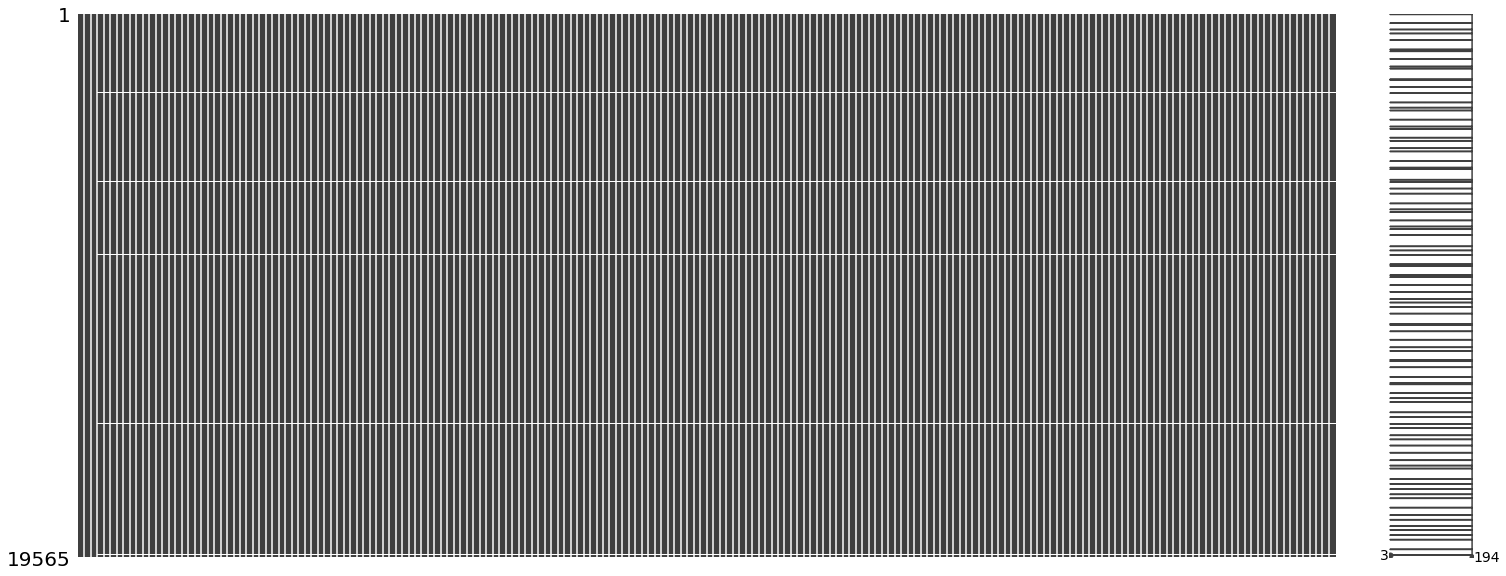

In [17]:
merged_frame = merged_frame.sort_values('Time')
msno.matrix(merged_frame)

In [18]:
## Check nulls
merged_frame.isna().sum().sort_values

<bound method Series.sort_values of Time                                            0
zip_code                                        0
zori_ssa                                        0
male_pop_32_month_shift                        91
female_pop_32_month_shift                      91
                                               ..
married_women_spouse_present_20_month_shift    91
men_with_hs_diploma_20_month_shift             91
quintile_5_mean_income_20_month_shift          91
quintile_2_mean_income_20_month_shift          91
male_75_to_79_20_month_shift                   91
Length: 194, dtype: int64>

In [19]:
## zip_code 75033 needs to be dropped
## show missing rows:
# merged_frame[merged_frame.isnull().any(axis=1)]


In [20]:
## Drop na values
merged_frame = merged_frame.dropna()
merged_frame = merged_frame.reset_index(drop=True)
print(f'shape: {merged_frame.shape}')

shape: (19474, 194)


In [21]:
## Check for categoricals
merged_frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19474 entries, 0 to 19473
Columns: 194 entries, Time to male_75_to_79_20_month_shift
dtypes: datetime64[ns](1), float64(192), int64(1)
memory usage: 28.8 MB


In [22]:
## Train will be before 12/1/2017, test is from 12/1/2017 to 12/1/2017
train_test_date = datetime.datetime(2020,12,1) 
merged_train = merged_frame[merged_frame['Time'] < train_test_date]
merged_test  = merged_frame[merged_frame['Time'] > train_test_date]

In [23]:
## Set features and target for test, train

y_train = merged_train[target_name]
y_test = merged_test[target_name]
X_test = merged_test.drop(columns=['zip_code', 'Time', target_name], axis=1)
X_train = merged_train.drop(columns=['zip_code', 'Time', target_name], axis=1)


In [24]:
### Run Catboost
# Testing performance
# RMSE: 161.08420537715583
# R2: 0.5135635682520305

train_dataset = cb.Pool(X_train, y_train)
test_dataset = cb.Pool(X_test, y_test)
model = cb.CatBoostRegressor(loss_function='RMSE')
grid = {'iterations': [100, 150, 100], 
       'learning_rate': [0.03, 01.], 
       'depth': [2,4,6,8], 
       'l2_leaf_reg': [0.2, 0.5, 1, 3]}

model.grid_search(grid, train_dataset)
feat_names = X_test.columns.to_list()

pred = model.predict(X_test)
rmse = (np.sqrt(mean_squared_error(y_test, pred)))
r2 = r2_score(y_test, pred)

print("Testing performance")
print(f'RMSE: {rmse}')
print(f'R2: {r2}')


0:	learn: 1305.7995445	test: 1301.9998090	best: 1301.9998090 (0)	total: 59ms	remaining: 5.84s
1:	learn: 1267.8148753	test: 1264.1114245	best: 1264.1114245 (1)	total: 64.4ms	remaining: 3.16s
2:	learn: 1231.1664357	test: 1227.4596604	best: 1227.4596604 (2)	total: 69.9ms	remaining: 2.26s
3:	learn: 1195.6743840	test: 1191.9749389	best: 1191.9749389 (3)	total: 75.1ms	remaining: 1.8s
4:	learn: 1161.1780287	test: 1157.5337134	best: 1157.5337134 (4)	total: 81.4ms	remaining: 1.55s
5:	learn: 1127.8149654	test: 1124.1862588	best: 1124.1862588 (5)	total: 86.3ms	remaining: 1.35s
6:	learn: 1095.5132308	test: 1091.8589173	best: 1091.8589173 (6)	total: 92.5ms	remaining: 1.23s
7:	learn: 1063.9999563	test: 1060.4185513	best: 1060.4185513 (7)	total: 97.9ms	remaining: 1.13s
8:	learn: 1033.6522079	test: 1030.0793745	best: 1030.0793745 (8)	total: 104ms	remaining: 1.05s
9:	learn: 1004.1045490	test: 1000.5681725	best: 1000.5681725 (9)	total: 109ms	remaining: 985ms
10:	learn: 975.6411017	test: 972.1090083	best

2:	learn: 188.2894588	test: 186.8474155	best: 186.8474155 (2)	total: 19.9ms	remaining: 645ms
3:	learn: 176.9196267	test: 176.8971175	best: 176.8971175 (3)	total: 26.2ms	remaining: 629ms
4:	learn: 168.5664924	test: 167.1554047	best: 167.1554047 (4)	total: 31.4ms	remaining: 597ms
5:	learn: 163.1270881	test: 163.1844165	best: 163.1844165 (5)	total: 36.4ms	remaining: 570ms
6:	learn: 159.2992819	test: 159.6526052	best: 159.6526052 (6)	total: 42.9ms	remaining: 569ms
7:	learn: 154.5463070	test: 154.8911719	best: 154.8911719 (7)	total: 48.7ms	remaining: 560ms
8:	learn: 150.9386028	test: 151.3937529	best: 151.3937529 (8)	total: 54ms	remaining: 546ms
9:	learn: 146.0695112	test: 146.3005302	best: 146.3005302 (9)	total: 58.9ms	remaining: 530ms
10:	learn: 142.4268486	test: 142.9420388	best: 142.9420388 (10)	total: 63.6ms	remaining: 514ms
11:	learn: 139.9173488	test: 141.1550236	best: 141.1550236 (11)	total: 68.7ms	remaining: 504ms
12:	learn: 136.0309324	test: 137.3783219	best: 137.3783219 (12)	tota

8:	learn: 1033.6755919	test: 1030.1030120	best: 1030.1030120 (8)	total: 48.9ms	remaining: 494ms
9:	learn: 1004.1300575	test: 1000.5939279	best: 1000.5939279 (9)	total: 54.6ms	remaining: 492ms
10:	learn: 975.6681611	test: 972.1365543	best: 972.1365543 (10)	total: 59.2ms	remaining: 479ms
11:	learn: 947.8238967	test: 944.3755616	best: 944.3755616 (11)	total: 64.5ms	remaining: 473ms
12:	learn: 921.0930319	test: 917.6885581	best: 917.6885581 (12)	total: 72.5ms	remaining: 485ms
13:	learn: 895.2353858	test: 891.8765319	best: 891.8765319 (13)	total: 78ms	remaining: 479ms
14:	learn: 869.9083126	test: 866.5807099	best: 866.5807099 (14)	total: 84.8ms	remaining: 481ms
15:	learn: 845.6950258	test: 842.4070559	best: 842.4070559 (15)	total: 90.1ms	remaining: 473ms
16:	learn: 822.2459645	test: 818.9796266	best: 818.9796266 (16)	total: 96.4ms	remaining: 471ms
17:	learn: 799.3883205	test: 796.1480019	best: 796.1480019 (17)	total: 103ms	remaining: 471ms
18:	learn: 777.0129218	test: 773.8193723	best: 773.

5:	learn: 163.1362585	test: 163.1863303	best: 163.1863303 (5)	total: 31.5ms	remaining: 493ms
6:	learn: 159.3070823	test: 159.6534125	best: 159.6534125 (6)	total: 36.2ms	remaining: 481ms
7:	learn: 154.5560883	test: 154.8933540	best: 154.8933540 (7)	total: 42.1ms	remaining: 485ms
8:	learn: 150.9393206	test: 151.3885434	best: 151.3885434 (8)	total: 46.9ms	remaining: 475ms
9:	learn: 146.0698837	test: 146.2947903	best: 146.2947903 (9)	total: 52.7ms	remaining: 475ms
10:	learn: 142.4251966	test: 142.9344288	best: 142.9344288 (10)	total: 58ms	remaining: 469ms
11:	learn: 139.9185495	test: 141.1472719	best: 141.1472719 (11)	total: 62.6ms	remaining: 459ms
12:	learn: 136.0327670	test: 137.3704353	best: 137.3704353 (12)	total: 67.5ms	remaining: 452ms
13:	learn: 133.3971069	test: 134.6323672	best: 134.6323672 (13)	total: 73ms	remaining: 449ms
14:	learn: 131.3905929	test: 133.2616870	best: 133.2616870 (14)	total: 78.1ms	remaining: 442ms
15:	learn: 128.8614507	test: 130.5446510	best: 130.5446510 (15)	

7:	learn: 1064.0571228	test: 1060.4767245	best: 1060.4767245 (7)	total: 66ms	remaining: 759ms
8:	learn: 1033.7144660	test: 1030.1422289	best: 1030.1422289 (8)	total: 75ms	remaining: 758ms
9:	learn: 1004.1724717	test: 1000.6366740	best: 1000.6366740 (9)	total: 88.3ms	remaining: 795ms
10:	learn: 975.7131488	test: 972.1822703	best: 972.1822703 (10)	total: 102ms	remaining: 829ms
11:	learn: 947.8711270	test: 944.4235602	best: 944.4235602 (11)	total: 115ms	remaining: 842ms
12:	learn: 921.1416383	test: 917.7378423	best: 917.7378423 (12)	total: 128ms	remaining: 855ms
13:	learn: 895.2863541	test: 891.9280783	best: 891.9280783 (13)	total: 162ms	remaining: 997ms
14:	learn: 869.9601838	test: 866.6331614	best: 866.6331614 (14)	total: 170ms	remaining: 963ms
15:	learn: 845.7489392	test: 842.4614667	best: 842.4614667 (15)	total: 187ms	remaining: 982ms
16:	learn: 822.3007203	test: 819.0348681	best: 819.0348681 (16)	total: 195ms	remaining: 950ms
17:	learn: 799.4445097	test: 796.2047040	best: 796.2047040

23:	learn: 113.6039400	test: 115.8665070	best: 115.8665070 (23)	total: 146ms	remaining: 463ms
24:	learn: 112.0565297	test: 114.6100001	best: 114.6100001 (24)	total: 160ms	remaining: 479ms
25:	learn: 109.9492345	test: 112.5533582	best: 112.5533582 (25)	total: 170ms	remaining: 483ms
26:	learn: 108.6167849	test: 111.0535705	best: 111.0535705 (26)	total: 182ms	remaining: 491ms
27:	learn: 107.5089850	test: 110.6665411	best: 110.6665411 (27)	total: 189ms	remaining: 486ms
28:	learn: 105.7194450	test: 107.9302932	best: 107.9302932 (28)	total: 200ms	remaining: 489ms
29:	learn: 104.4684110	test: 107.0370867	best: 107.0370867 (29)	total: 207ms	remaining: 484ms
30:	learn: 102.7253218	test: 105.4586647	best: 105.4586647 (30)	total: 214ms	remaining: 477ms
31:	learn: 101.3888802	test: 104.0272898	best: 104.0272898 (31)	total: 219ms	remaining: 466ms
32:	learn: 100.0722806	test: 103.0401181	best: 103.0401181 (32)	total: 224ms	remaining: 456ms
33:	learn: 98.5743613	test: 101.6616501	best: 101.6616501 (3

33:	learn: 518.2932887	test: 515.4740123	best: 515.4740123 (33)	total: 136ms	remaining: 264ms
34:	learn: 504.9600960	test: 502.2096162	best: 502.2096162 (34)	total: 142ms	remaining: 263ms
35:	learn: 492.5455374	test: 489.7886141	best: 489.7886141 (35)	total: 147ms	remaining: 261ms
36:	learn: 480.0806415	test: 477.3419264	best: 477.3419264 (36)	total: 152ms	remaining: 260ms
37:	learn: 468.2009184	test: 465.5009284	best: 465.5009284 (37)	total: 158ms	remaining: 258ms
38:	learn: 456.8325591	test: 454.1404979	best: 454.1404979 (38)	total: 164ms	remaining: 257ms
39:	learn: 445.8713086	test: 443.1894848	best: 443.1894848 (39)	total: 172ms	remaining: 258ms
40:	learn: 435.1088083	test: 432.4947466	best: 432.4947466 (40)	total: 178ms	remaining: 256ms
41:	learn: 424.7394247	test: 422.1612650	best: 422.1612650 (41)	total: 184ms	remaining: 254ms
42:	learn: 414.7925058	test: 412.2540152	best: 412.2540152 (42)	total: 190ms	remaining: 251ms
43:	learn: 405.2141833	test: 402.6975248	best: 402.6975248 (

38:	learn: 92.4056922	test: 95.0252009	best: 95.0252009 (38)	total: 215ms	remaining: 337ms
39:	learn: 91.3803139	test: 94.0838690	best: 94.0838690 (39)	total: 220ms	remaining: 331ms
40:	learn: 90.6943220	test: 93.6987632	best: 93.6987632 (40)	total: 226ms	remaining: 326ms
41:	learn: 89.6636414	test: 92.9096260	best: 92.9096260 (41)	total: 231ms	remaining: 319ms
42:	learn: 88.4375382	test: 91.6831750	best: 91.6831750 (42)	total: 236ms	remaining: 313ms
43:	learn: 87.3042457	test: 90.9295243	best: 90.9295243 (43)	total: 241ms	remaining: 307ms
44:	learn: 86.3506281	test: 90.1643975	best: 90.1643975 (44)	total: 246ms	remaining: 301ms
45:	learn: 85.5671925	test: 89.6389679	best: 89.6389679 (45)	total: 252ms	remaining: 295ms
46:	learn: 84.6606900	test: 88.4739314	best: 88.4739314 (46)	total: 257ms	remaining: 290ms
47:	learn: 83.9074651	test: 87.4483727	best: 87.4483727 (47)	total: 262ms	remaining: 284ms
48:	learn: 83.1515218	test: 87.0092663	best: 87.0092663 (48)	total: 268ms	remaining: 279ms

58:	learn: 295.9564589	test: 293.8430575	best: 293.8430575 (58)	total: 249ms	remaining: 384ms
59:	learn: 290.6633536	test: 288.5400635	best: 288.5400635 (59)	total: 253ms	remaining: 380ms
60:	learn: 285.5484411	test: 283.4366991	best: 283.4366991 (60)	total: 258ms	remaining: 376ms
61:	learn: 280.6976099	test: 278.6139780	best: 278.6139780 (61)	total: 263ms	remaining: 373ms
62:	learn: 275.9491225	test: 274.0321451	best: 274.0321451 (62)	total: 267ms	remaining: 369ms
63:	learn: 271.4333553	test: 269.5885930	best: 269.5885930 (63)	total: 272ms	remaining: 366ms
64:	learn: 266.9759104	test: 265.1410032	best: 265.1410032 (64)	total: 277ms	remaining: 363ms
65:	learn: 262.7773613	test: 260.9621532	best: 260.9621532 (65)	total: 283ms	remaining: 360ms
66:	learn: 258.7822777	test: 257.0020695	best: 257.0020695 (66)	total: 287ms	remaining: 355ms
67:	learn: 254.8551125	test: 253.0920103	best: 253.0920103 (67)	total: 290ms	remaining: 350ms
68:	learn: 251.0752117	test: 249.3798388	best: 249.3798388 (

3:	learn: 176.9196267	test: 176.8971175	best: 176.8971175 (3)	total: 24.8ms	remaining: 907ms
4:	learn: 168.5664924	test: 167.1554047	best: 167.1554047 (4)	total: 29.9ms	remaining: 868ms
5:	learn: 163.1270881	test: 163.1844165	best: 163.1844165 (5)	total: 35.9ms	remaining: 862ms
6:	learn: 159.2992819	test: 159.6526052	best: 159.6526052 (6)	total: 40.8ms	remaining: 833ms
7:	learn: 154.5463070	test: 154.8911719	best: 154.8911719 (7)	total: 46.2ms	remaining: 821ms
8:	learn: 150.9386028	test: 151.3937529	best: 151.3937529 (8)	total: 51.7ms	remaining: 810ms
9:	learn: 146.0695112	test: 146.3005302	best: 146.3005302 (9)	total: 56.8ms	remaining: 795ms
10:	learn: 142.4268486	test: 142.9420388	best: 142.9420388 (10)	total: 61.8ms	remaining: 781ms
11:	learn: 139.9173488	test: 141.1550236	best: 141.1550236 (11)	total: 67.6ms	remaining: 778ms
12:	learn: 136.0309324	test: 137.3783219	best: 137.3783219 (12)	total: 72.6ms	remaining: 765ms
13:	learn: 133.3958853	test: 134.6404800	best: 134.6404800 (13)	

103:	learn: 55.0921912	test: 59.4262373	best: 59.4262373 (103)	total: 621ms	remaining: 275ms
104:	learn: 54.8235847	test: 59.4131119	best: 59.4131119 (104)	total: 628ms	remaining: 269ms
105:	learn: 54.4956771	test: 59.0179717	best: 59.0179717 (105)	total: 633ms	remaining: 263ms
106:	learn: 54.2932149	test: 58.7918219	best: 58.7918219 (106)	total: 638ms	remaining: 257ms
107:	learn: 54.0310351	test: 58.6403461	best: 58.6403461 (107)	total: 643ms	remaining: 250ms
108:	learn: 53.7686141	test: 58.2388542	best: 58.2388542 (108)	total: 648ms	remaining: 244ms
109:	learn: 53.5625979	test: 57.9592814	best: 57.9592814 (109)	total: 654ms	remaining: 238ms
110:	learn: 53.3092040	test: 57.7266561	best: 57.7266561 (110)	total: 660ms	remaining: 232ms
111:	learn: 53.0982010	test: 57.3284922	best: 57.3284922 (111)	total: 666ms	remaining: 226ms
112:	learn: 52.7072714	test: 56.8590349	best: 56.8590349 (112)	total: 673ms	remaining: 220ms
113:	learn: 52.3760644	test: 56.6119978	best: 56.6119978 (113)	total: 

45:	learn: 386.8286354	test: 384.3678989	best: 384.3678989 (45)	total: 157ms	remaining: 355ms
46:	learn: 378.2920303	test: 375.8345693	best: 375.8345693 (46)	total: 162ms	remaining: 355ms
47:	learn: 370.0611270	test: 367.6139313	best: 367.6139313 (47)	total: 167ms	remaining: 355ms
48:	learn: 361.8887730	test: 359.4643681	best: 359.4643681 (48)	total: 173ms	remaining: 356ms
49:	learn: 354.0643254	test: 351.6618498	best: 351.6618498 (49)	total: 178ms	remaining: 357ms
50:	learn: 346.4891599	test: 344.1508357	best: 344.1508357 (50)	total: 185ms	remaining: 358ms
51:	learn: 339.3125467	test: 337.0111340	best: 337.0111340 (51)	total: 190ms	remaining: 358ms
52:	learn: 332.2794659	test: 329.9766872	best: 329.9766872 (52)	total: 196ms	remaining: 359ms
53:	learn: 325.6020268	test: 323.3351965	best: 323.3351965 (53)	total: 200ms	remaining: 356ms
54:	learn: 319.0832619	test: 316.8443088	best: 316.8443088 (54)	total: 204ms	remaining: 352ms
55:	learn: 312.9800973	test: 310.7634519	best: 310.7634519 (

4:	learn: 168.5734838	test: 167.1567104	best: 167.1567104 (4)	total: 29.9ms	remaining: 866ms
5:	learn: 163.1362585	test: 163.1863303	best: 163.1863303 (5)	total: 35.7ms	remaining: 856ms
6:	learn: 159.3070823	test: 159.6534125	best: 159.6534125 (6)	total: 41.2ms	remaining: 841ms
7:	learn: 154.5560883	test: 154.8933540	best: 154.8933540 (7)	total: 46.8ms	remaining: 832ms
8:	learn: 150.9393206	test: 151.3885434	best: 151.3885434 (8)	total: 52.8ms	remaining: 827ms
9:	learn: 146.0698837	test: 146.2947903	best: 146.2947903 (9)	total: 58.6ms	remaining: 820ms
10:	learn: 142.4251966	test: 142.9344288	best: 142.9344288 (10)	total: 65.3ms	remaining: 825ms
11:	learn: 139.9185495	test: 141.1472719	best: 141.1472719 (11)	total: 70.2ms	remaining: 808ms
12:	learn: 136.0327670	test: 137.3704353	best: 137.3704353 (12)	total: 76ms	remaining: 801ms
13:	learn: 133.3971069	test: 134.6323672	best: 134.6323672 (13)	total: 81.4ms	remaining: 791ms
14:	learn: 131.3905929	test: 133.2616870	best: 133.2616870 (14)	

98:	learn: 57.2062847	test: 60.1436214	best: 60.1436214 (98)	total: 631ms	remaining: 325ms
99:	learn: 56.7614615	test: 59.8181495	best: 59.8181495 (99)	total: 652ms	remaining: 326ms
100:	learn: 56.4755334	test: 59.4962947	best: 59.4962947 (100)	total: 662ms	remaining: 321ms
101:	learn: 56.1514060	test: 59.2994622	best: 59.2994622 (101)	total: 670ms	remaining: 315ms
102:	learn: 55.8342723	test: 59.0723704	best: 59.0723704 (102)	total: 676ms	remaining: 309ms
103:	learn: 55.5324367	test: 58.9689050	best: 58.9689050 (103)	total: 685ms	remaining: 303ms
104:	learn: 55.1947876	test: 58.5789137	best: 58.5789137 (104)	total: 701ms	remaining: 301ms
105:	learn: 54.8575319	test: 58.3517768	best: 58.3517768 (105)	total: 710ms	remaining: 295ms
106:	learn: 54.4954552	test: 57.8438899	best: 57.8438899 (106)	total: 718ms	remaining: 288ms
107:	learn: 54.1963831	test: 57.5229692	best: 57.5229692 (107)	total: 722ms	remaining: 281ms
108:	learn: 53.9556437	test: 57.1878831	best: 57.1878831 (108)	total: 728m

62:	learn: 275.8814487	test: 273.8379740	best: 273.8379740 (62)	total: 296ms	remaining: 408ms
63:	learn: 271.2707570	test: 269.2447355	best: 269.2447355 (63)	total: 300ms	remaining: 404ms
64:	learn: 266.8101012	test: 264.7943564	best: 264.7943564 (64)	total: 305ms	remaining: 399ms
65:	learn: 262.6056914	test: 260.6116150	best: 260.6116150 (65)	total: 310ms	remaining: 394ms
66:	learn: 258.6040564	test: 256.6460006	best: 256.6460006 (66)	total: 314ms	remaining: 389ms
67:	learn: 254.6710677	test: 252.7301417	best: 252.7301417 (67)	total: 320ms	remaining: 386ms
68:	learn: 250.8918886	test: 249.0187347	best: 249.0187347 (68)	total: 327ms	remaining: 384ms
69:	learn: 247.2295914	test: 245.3652058	best: 245.3652058 (69)	total: 331ms	remaining: 378ms
70:	learn: 243.8077184	test: 241.9660224	best: 241.9660224 (70)	total: 335ms	remaining: 372ms
71:	learn: 240.5079822	test: 238.7368708	best: 238.7368708 (71)	total: 340ms	remaining: 368ms
72:	learn: 237.2258458	test: 235.4700882	best: 235.4700882 (

11:	learn: 139.9217505	test: 141.1356497	best: 141.1356497 (11)	total: 49.2ms	remaining: 566ms
12:	learn: 136.0370528	test: 137.3586203	best: 137.3586203 (12)	total: 54.1ms	remaining: 570ms
13:	learn: 133.4005696	test: 134.6204047	best: 134.6204047 (13)	total: 59ms	remaining: 574ms
14:	learn: 131.3878996	test: 133.2441221	best: 133.2441221 (14)	total: 64.4ms	remaining: 579ms
15:	learn: 128.8598102	test: 130.5279035	best: 130.5279035 (15)	total: 69.6ms	remaining: 583ms
16:	learn: 126.6841078	test: 128.6055325	best: 128.6055325 (16)	total: 74.2ms	remaining: 581ms
17:	learn: 124.6529243	test: 126.6730235	best: 126.6730235 (17)	total: 80.1ms	remaining: 587ms
18:	learn: 122.5034409	test: 124.1165528	best: 124.1165528 (18)	total: 84.4ms	remaining: 582ms
19:	learn: 120.4848233	test: 121.9891344	best: 121.9891344 (19)	total: 90.3ms	remaining: 587ms
20:	learn: 118.0099728	test: 120.1199658	best: 120.1199658 (20)	total: 95.2ms	remaining: 585ms
21:	learn: 116.4663402	test: 118.5133574	best: 118.5

116:	learn: 50.9455793	test: 55.1176838	best: 55.1176838 (116)	total: 436ms	remaining: 123ms
117:	learn: 50.6221874	test: 54.9538104	best: 54.9538104 (117)	total: 440ms	remaining: 119ms
118:	learn: 50.3388301	test: 54.6126949	best: 54.6126949 (118)	total: 445ms	remaining: 116ms
119:	learn: 50.0047814	test: 54.4525986	best: 54.4525986 (119)	total: 449ms	remaining: 112ms
120:	learn: 49.7707670	test: 54.1474724	best: 54.1474724 (120)	total: 454ms	remaining: 109ms
121:	learn: 49.5017238	test: 53.8698800	best: 53.8698800 (121)	total: 458ms	remaining: 105ms
122:	learn: 49.2014677	test: 53.5711013	best: 53.5711013 (122)	total: 463ms	remaining: 102ms
123:	learn: 48.9426896	test: 53.1942216	best: 53.1942216 (123)	total: 469ms	remaining: 98.2ms
124:	learn: 48.6612032	test: 53.0154615	best: 53.0154615 (124)	total: 473ms	remaining: 94.6ms
125:	learn: 48.3455253	test: 52.6596824	best: 52.6596824 (125)	total: 477ms	remaining: 90.9ms
126:	learn: 48.0892952	test: 52.3368188	best: 52.3368188 (126)	tota

69:	learn: 247.4286987	test: 245.5716981	best: 245.5716981 (69)	total: 262ms	remaining: 300ms
70:	learn: 244.0031985	test: 242.1687638	best: 242.1687638 (70)	total: 267ms	remaining: 297ms
71:	learn: 240.6992719	test: 238.9352374	best: 238.9352374 (71)	total: 272ms	remaining: 294ms
72:	learn: 237.4137598	test: 235.6649656	best: 235.6649656 (72)	total: 277ms	remaining: 292ms
73:	learn: 234.3332676	test: 232.6217307	best: 232.6217307 (73)	total: 281ms	remaining: 288ms
74:	learn: 231.4363803	test: 229.7574852	best: 229.7574852 (74)	total: 285ms	remaining: 285ms
75:	learn: 228.5273525	test: 226.8350148	best: 226.8350148 (75)	total: 291ms	remaining: 284ms
76:	learn: 225.7005486	test: 223.9966917	best: 223.9966917 (76)	total: 299ms	remaining: 283ms
77:	learn: 223.1303624	test: 221.4788383	best: 221.4788383 (77)	total: 303ms	remaining: 280ms
78:	learn: 220.6772212	test: 219.1069246	best: 219.1069246 (78)	total: 307ms	remaining: 276ms
79:	learn: 218.2768104	test: 216.7257477	best: 216.7257477 (

14:	learn: 131.3947076	test: 133.1930558	best: 133.1930558 (14)	total: 59.7ms	remaining: 538ms
15:	learn: 128.8707613	test: 130.4801108	best: 130.4801108 (15)	total: 64.4ms	remaining: 539ms
16:	learn: 126.6955015	test: 128.5600988	best: 128.5600988 (16)	total: 68.8ms	remaining: 538ms
17:	learn: 124.6586948	test: 126.6343829	best: 126.6343829 (17)	total: 73.4ms	remaining: 539ms
18:	learn: 122.5045807	test: 124.0682873	best: 124.0682873 (18)	total: 78.3ms	remaining: 540ms
19:	learn: 119.9605356	test: 122.2082595	best: 122.2082595 (19)	total: 83.1ms	remaining: 540ms
20:	learn: 118.4556005	test: 120.9577113	best: 120.9577113 (20)	total: 88.3ms	remaining: 542ms
21:	learn: 116.2987154	test: 119.1566426	best: 119.1566426 (21)	total: 91.9ms	remaining: 535ms
22:	learn: 115.0203874	test: 117.7455827	best: 117.7455827 (22)	total: 96.6ms	remaining: 533ms
23:	learn: 112.7868323	test: 115.1619082	best: 115.1619082 (23)	total: 100ms	remaining: 525ms
24:	learn: 110.5277799	test: 112.7665402	best: 112.

125:	learn: 48.6293029	test: 51.4872984	best: 51.4872984 (125)	total: 450ms	remaining: 85.7ms
126:	learn: 48.3707273	test: 51.1660085	best: 51.1660085 (126)	total: 455ms	remaining: 82.4ms
127:	learn: 48.1111857	test: 51.0505721	best: 51.0505721 (127)	total: 460ms	remaining: 79ms
128:	learn: 47.8894117	test: 50.5313383	best: 50.5313383 (128)	total: 464ms	remaining: 75.5ms
129:	learn: 47.5676256	test: 50.5249283	best: 50.5249283 (129)	total: 468ms	remaining: 72ms
130:	learn: 47.4039834	test: 50.3026912	best: 50.3026912 (130)	total: 473ms	remaining: 68.5ms
131:	learn: 47.1867680	test: 50.1562145	best: 50.1562145 (131)	total: 478ms	remaining: 65.1ms
132:	learn: 47.0515176	test: 50.1145289	best: 50.1145289 (132)	total: 482ms	remaining: 61.7ms
133:	learn: 46.7835931	test: 49.7601456	best: 49.7601456 (133)	total: 486ms	remaining: 58ms
134:	learn: 46.4394224	test: 49.4946294	best: 49.4946294 (134)	total: 490ms	remaining: 54.4ms
135:	learn: 46.2157639	test: 49.3296549	best: 49.3296549 (135)	tot

82:	learn: 211.6194898	test: 210.3966405	best: 210.3966405 (82)	total: 299ms	remaining: 61.2ms
83:	learn: 209.5969357	test: 208.3901236	best: 208.3901236 (83)	total: 303ms	remaining: 57.8ms
84:	learn: 207.5999645	test: 206.4484801	best: 206.4484801 (84)	total: 308ms	remaining: 54.3ms
85:	learn: 205.7082411	test: 204.5417578	best: 204.5417578 (85)	total: 314ms	remaining: 51ms
86:	learn: 203.8631478	test: 202.7223431	best: 202.7223431 (86)	total: 320ms	remaining: 47.8ms
87:	learn: 202.1057075	test: 200.9763608	best: 200.9763608 (87)	total: 326ms	remaining: 44.5ms
88:	learn: 200.3961766	test: 199.2976931	best: 199.2976931 (88)	total: 330ms	remaining: 40.8ms
89:	learn: 198.7232595	test: 197.6269050	best: 197.6269050 (89)	total: 334ms	remaining: 37.1ms
90:	learn: 197.1561625	test: 196.0709502	best: 196.0709502 (90)	total: 337ms	remaining: 33.4ms
91:	learn: 195.5765415	test: 194.5082265	best: 194.5082265 (91)	total: 341ms	remaining: 29.6ms
92:	learn: 194.1315971	test: 193.1695492	best: 193.1

84:	learn: 62.3418597	test: 66.3239877	best: 66.3239877 (84)	total: 313ms	remaining: 55.3ms
85:	learn: 61.9024438	test: 65.6788640	best: 65.6788640 (85)	total: 318ms	remaining: 51.7ms
86:	learn: 61.5682888	test: 65.4184545	best: 65.4184545 (86)	total: 322ms	remaining: 48.1ms
87:	learn: 61.0967370	test: 64.9828110	best: 64.9828110 (87)	total: 326ms	remaining: 44.5ms
88:	learn: 60.8144184	test: 64.6383341	best: 64.6383341 (88)	total: 330ms	remaining: 40.8ms
89:	learn: 60.5207133	test: 64.3461845	best: 64.3461845 (89)	total: 336ms	remaining: 37.3ms
90:	learn: 60.1296281	test: 64.0448013	best: 64.0448013 (90)	total: 341ms	remaining: 33.8ms
91:	learn: 59.7218502	test: 63.7770625	best: 63.7770625 (91)	total: 345ms	remaining: 30ms
92:	learn: 59.2924994	test: 63.2818494	best: 63.2818494 (92)	total: 349ms	remaining: 26.3ms
93:	learn: 58.7488752	test: 62.5319718	best: 62.5319718 (93)	total: 354ms	remaining: 22.6ms
94:	learn: 58.3923972	test: 62.1567552	best: 62.1567552 (94)	total: 357ms	remainin

91:	learn: 195.6002600	test: 194.5316931	best: 194.5316931 (91)	total: 330ms	remaining: 28.7ms
92:	learn: 194.1551946	test: 193.1927087	best: 193.1927087 (92)	total: 334ms	remaining: 25.2ms
93:	learn: 192.7729496	test: 191.8727507	best: 191.8727507 (93)	total: 339ms	remaining: 21.6ms
94:	learn: 191.4431983	test: 190.5848674	best: 190.5848674 (94)	total: 344ms	remaining: 18.1ms
95:	learn: 190.1852961	test: 189.3431193	best: 189.3431193 (95)	total: 349ms	remaining: 14.5ms
96:	learn: 188.9831682	test: 188.1654516	best: 188.1654516 (96)	total: 353ms	remaining: 10.9ms
97:	learn: 187.8782224	test: 187.0997484	best: 187.0997484 (97)	total: 359ms	remaining: 7.32ms
98:	learn: 186.7429986	test: 185.9738717	best: 185.9738717 (98)	total: 362ms	remaining: 3.66ms
99:	learn: 185.6092773	test: 184.8366154	best: 184.8366154 (99)	total: 366ms	remaining: 0us

bestTest = 184.8366154
bestIteration = 99

18:	loss: 184.8366154	best: 46.0942074 (15)	total: 11.8s	remaining: 47.8s
0:	learn: 222.3259656	test: 22

98:	learn: 57.2062847	test: 60.1436214	best: 60.1436214 (98)	total: 355ms	remaining: 3.59ms
99:	learn: 56.7614615	test: 59.8181495	best: 59.8181495 (99)	total: 360ms	remaining: 0us

bestTest = 59.81814946
bestIteration = 99

19:	loss: 59.8181495	best: 46.0942074 (15)	total: 12.2s	remaining: 46.3s
0:	learn: 1305.8089909	test: 1302.0092697	best: 1302.0092697 (0)	total: 5.77ms	remaining: 571ms
1:	learn: 1267.8346197	test: 1264.1309691	best: 1264.1309691 (1)	total: 10ms	remaining: 490ms
2:	learn: 1231.1923163	test: 1227.4855456	best: 1227.4855456 (2)	total: 14.5ms	remaining: 469ms
3:	learn: 1195.7076994	test: 1192.0078763	best: 1192.0078763 (3)	total: 19.7ms	remaining: 472ms
4:	learn: 1161.2187401	test: 1157.5755795	best: 1157.5755795 (4)	total: 24.1ms	remaining: 458ms
5:	learn: 1127.8608915	test: 1124.2332737	best: 1124.2332737 (5)	total: 28.3ms	remaining: 443ms
6:	learn: 1095.5648338	test: 1091.9115149	best: 1091.9115149 (6)	total: 31.7ms	remaining: 422ms
7:	learn: 1064.0571228	test: 106

1:	learn: 200.2209644	test: 198.1393192	best: 198.1393192 (1)	total: 17.2ms	remaining: 843ms
2:	learn: 188.2668707	test: 186.8217230	best: 186.8217230 (2)	total: 24.3ms	remaining: 787ms
3:	learn: 176.8831329	test: 176.8389573	best: 176.8389573 (3)	total: 29.8ms	remaining: 715ms
4:	learn: 168.5853376	test: 167.1592421	best: 167.1592421 (4)	total: 35ms	remaining: 666ms
5:	learn: 163.1521932	test: 163.1902329	best: 163.1902329 (5)	total: 41.8ms	remaining: 655ms
6:	learn: 159.3208064	test: 159.6555756	best: 159.6555756 (6)	total: 49.8ms	remaining: 661ms
7:	learn: 154.5730903	test: 154.8977738	best: 154.8977738 (7)	total: 55.5ms	remaining: 638ms
8:	learn: 150.9413788	test: 151.3808001	best: 151.3808001 (8)	total: 60.2ms	remaining: 609ms
9:	learn: 146.0715839	test: 146.2863822	best: 146.2863822 (9)	total: 63.4ms	remaining: 571ms
10:	learn: 142.4235919	test: 142.9229936	best: 142.9229936 (10)	total: 66.5ms	remaining: 538ms
11:	learn: 139.9217505	test: 141.1356497	best: 141.1356497 (11)	total:

92:	learn: 58.3731234	test: 62.7148406	best: 62.7148406 (92)	total: 414ms	remaining: 31.2ms
93:	learn: 57.9194792	test: 62.2416340	best: 62.2416340 (93)	total: 419ms	remaining: 26.7ms
94:	learn: 57.6427717	test: 62.0573748	best: 62.0573748 (94)	total: 423ms	remaining: 22.3ms
95:	learn: 57.3781358	test: 61.8027260	best: 61.8027260 (95)	total: 429ms	remaining: 17.9ms
96:	learn: 57.0252367	test: 61.5086682	best: 61.5086682 (96)	total: 435ms	remaining: 13.5ms
97:	learn: 56.7307288	test: 61.1106205	best: 61.1106205 (97)	total: 441ms	remaining: 9ms
98:	learn: 56.4889415	test: 60.8729624	best: 60.8729624 (98)	total: 444ms	remaining: 4.49ms
99:	learn: 56.0966292	test: 60.4892104	best: 60.4892104 (99)	total: 448ms	remaining: 0us

bestTest = 60.48921044
bestIteration = 99

21:	loss: 60.4892104	best: 46.0942074 (15)	total: 13s	remaining: 43.8s
0:	learn: 1305.8325775	test: 1302.0328922	best: 1302.0328922 (0)	total: 4.26ms	remaining: 422ms
1:	learn: 1267.8838475	test: 1264.1796978	best: 1264.179697

94:	learn: 191.3688869	test: 190.4017394	best: 190.4017394 (94)	total: 359ms	remaining: 18.9ms
95:	learn: 190.0478605	test: 189.0937431	best: 189.0937431 (95)	total: 371ms	remaining: 15.4ms
96:	learn: 188.8366026	test: 187.9013375	best: 187.9013375 (96)	total: 384ms	remaining: 11.9ms
97:	learn: 187.7299759	test: 186.8345099	best: 186.8345099 (97)	total: 393ms	remaining: 8.02ms
98:	learn: 186.6063893	test: 185.7205834	best: 185.7205834 (98)	total: 400ms	remaining: 4.04ms
99:	learn: 185.4889365	test: 184.6001605	best: 184.6001605 (99)	total: 406ms	remaining: 0us

bestTest = 184.6001605
bestIteration = 99

22:	loss: 184.6001605	best: 46.0942074 (15)	total: 13.5s	remaining: 42.7s
0:	learn: 222.3306067	test: 220.4024670	best: 220.4024670 (0)	total: 9.51ms	remaining: 941ms
1:	learn: 200.1506573	test: 198.0603658	best: 198.0603658 (1)	total: 16.1ms	remaining: 791ms
2:	learn: 188.2117719	test: 186.7588656	best: 186.7588656 (2)	total: 21.2ms	remaining: 686ms
3:	learn: 176.7974191	test: 176.7012

91:	learn: 59.0527545	test: 61.6714258	best: 61.6714258 (91)	total: 340ms	remaining: 29.6ms
92:	learn: 58.6239263	test: 61.2655530	best: 61.2655530 (92)	total: 345ms	remaining: 26ms
93:	learn: 58.1885888	test: 60.6696473	best: 60.6696473 (93)	total: 353ms	remaining: 22.5ms
94:	learn: 57.9394946	test: 60.4602765	best: 60.4602765 (94)	total: 361ms	remaining: 19ms
95:	learn: 57.6214501	test: 60.1088612	best: 60.1088612 (95)	total: 368ms	remaining: 15.3ms
96:	learn: 57.2679941	test: 59.4416794	best: 59.4416794 (96)	total: 374ms	remaining: 11.6ms
97:	learn: 56.8738041	test: 59.1321508	best: 59.1321508 (97)	total: 379ms	remaining: 7.74ms
98:	learn: 56.5624899	test: 58.7287413	best: 58.7287413 (98)	total: 385ms	remaining: 3.89ms
99:	learn: 56.3013294	test: 58.3938250	best: 58.3938250 (99)	total: 388ms	remaining: 0us

bestTest = 58.39382501
bestIteration = 99

23:	loss: 58.3938250	best: 46.0942074 (15)	total: 13.9s	remaining: 41.6s
0:	learn: 1305.7592381	test: 1301.9347986	best: 1301.9347986 (

82:	learn: 195.4054680	test: 194.4565627	best: 194.4565627 (82)	total: 545ms	remaining: 112ms
83:	learn: 193.0554035	test: 192.1548811	best: 192.1548811 (83)	total: 554ms	remaining: 106ms
84:	learn: 190.8147949	test: 189.9621245	best: 189.9621245 (84)	total: 562ms	remaining: 99.2ms
85:	learn: 188.6478385	test: 187.8465453	best: 187.8465453 (85)	total: 571ms	remaining: 93ms
86:	learn: 186.5865098	test: 185.8133882	best: 185.8133882 (86)	total: 579ms	remaining: 86.5ms
87:	learn: 184.5920686	test: 183.9291883	best: 183.9291883 (87)	total: 587ms	remaining: 80ms
88:	learn: 182.7130397	test: 182.0878353	best: 182.0878353 (88)	total: 593ms	remaining: 73.2ms
89:	learn: 180.8547856	test: 180.2268310	best: 180.2268310 (89)	total: 599ms	remaining: 66.6ms
90:	learn: 179.1341019	test: 178.5528759	best: 178.5528759 (90)	total: 605ms	remaining: 59.8ms
91:	learn: 177.4277535	test: 176.9049576	best: 176.9049576 (91)	total: 611ms	remaining: 53.1ms
92:	learn: 175.7032981	test: 175.1937141	best: 175.19371

74:	learn: 34.5926248	test: 38.8326482	best: 38.8326482 (74)	total: 484ms	remaining: 161ms
75:	learn: 34.2074945	test: 38.6144384	best: 38.6144384 (75)	total: 492ms	remaining: 155ms
76:	learn: 33.9197693	test: 38.1931467	best: 38.1931467 (76)	total: 500ms	remaining: 149ms
77:	learn: 33.6686795	test: 38.0266623	best: 38.0266623 (77)	total: 509ms	remaining: 144ms
78:	learn: 33.2289078	test: 37.5605656	best: 37.5605656 (78)	total: 516ms	remaining: 137ms
79:	learn: 32.7924631	test: 37.1166841	best: 37.1166841 (79)	total: 524ms	remaining: 131ms
80:	learn: 32.3763617	test: 36.6815331	best: 36.6815331 (80)	total: 531ms	remaining: 125ms
81:	learn: 32.0192587	test: 36.2548498	best: 36.2548498 (81)	total: 537ms	remaining: 118ms
82:	learn: 31.7959543	test: 36.0900822	best: 36.0900822 (82)	total: 543ms	remaining: 111ms
83:	learn: 31.4307784	test: 35.7329921	best: 35.7329921 (83)	total: 549ms	remaining: 105ms
84:	learn: 31.0168094	test: 35.4106681	best: 35.4106681 (84)	total: 556ms	remaining: 98.1m

66:	learn: 246.7847593	test: 245.0036241	best: 245.0036241 (66)	total: 437ms	remaining: 215ms
67:	learn: 242.5104937	test: 240.7423025	best: 240.7423025 (67)	total: 446ms	remaining: 210ms
68:	learn: 238.3741823	test: 236.6705784	best: 236.6705784 (68)	total: 454ms	remaining: 204ms
69:	learn: 234.5516416	test: 232.8780813	best: 232.8780813 (69)	total: 463ms	remaining: 198ms
70:	learn: 230.8911340	test: 229.3037629	best: 229.3037629 (70)	total: 470ms	remaining: 192ms
71:	learn: 227.2554001	test: 225.6738669	best: 225.6738669 (71)	total: 475ms	remaining: 185ms
72:	learn: 223.6556180	test: 222.1117599	best: 222.1117599 (72)	total: 483ms	remaining: 179ms
73:	learn: 220.2479703	test: 218.7762614	best: 218.7762614 (73)	total: 491ms	remaining: 173ms
74:	learn: 216.9898526	test: 215.6060845	best: 215.6060845 (74)	total: 499ms	remaining: 166ms
75:	learn: 213.7853294	test: 212.4238457	best: 212.4238457 (75)	total: 505ms	remaining: 160ms
76:	learn: 210.8999365	test: 209.5291473	best: 209.5291473 (

77:	learn: 34.5291818	test: 38.0092034	best: 38.0092034 (77)	total: 559ms	remaining: 158ms
78:	learn: 34.2310878	test: 37.8125530	best: 37.8125530 (78)	total: 567ms	remaining: 151ms
79:	learn: 33.9332476	test: 37.5773391	best: 37.5773391 (79)	total: 574ms	remaining: 144ms
80:	learn: 33.5652908	test: 37.3496958	best: 37.3496958 (80)	total: 582ms	remaining: 137ms
81:	learn: 33.2882998	test: 37.1799091	best: 37.1799091 (81)	total: 591ms	remaining: 130ms
82:	learn: 32.9402509	test: 36.8703326	best: 36.8703326 (82)	total: 598ms	remaining: 123ms
83:	learn: 32.5150512	test: 36.3471009	best: 36.3471009 (83)	total: 605ms	remaining: 115ms
84:	learn: 32.1619533	test: 35.9362022	best: 35.9362022 (84)	total: 612ms	remaining: 108ms
85:	learn: 31.6799573	test: 35.5772096	best: 35.5772096 (85)	total: 618ms	remaining: 101ms
86:	learn: 31.4244252	test: 35.2836027	best: 35.2836027 (86)	total: 624ms	remaining: 93.2ms
87:	learn: 31.1251230	test: 35.1012506	best: 35.1012506 (87)	total: 630ms	remaining: 85.9

67:	learn: 242.6869708	test: 240.9173346	best: 240.9173346 (67)	total: 451ms	remaining: 212ms
68:	learn: 238.5473074	test: 236.8421803	best: 236.8421803 (68)	total: 460ms	remaining: 207ms
69:	learn: 234.5985801	test: 232.9457970	best: 232.9457970 (69)	total: 469ms	remaining: 201ms
70:	learn: 230.9453032	test: 229.3473929	best: 229.3473929 (70)	total: 478ms	remaining: 195ms
71:	learn: 227.3045342	test: 225.7133541	best: 225.7133541 (71)	total: 485ms	remaining: 188ms
72:	learn: 223.7008795	test: 222.1482217	best: 222.1482217 (72)	total: 491ms	remaining: 182ms
73:	learn: 220.2890404	test: 218.8101164	best: 218.8101164 (73)	total: 498ms	remaining: 175ms
74:	learn: 217.0292467	test: 215.6389976	best: 215.6389976 (74)	total: 505ms	remaining: 168ms
75:	learn: 213.9857294	test: 212.5843519	best: 212.5843519 (75)	total: 511ms	remaining: 161ms
76:	learn: 211.0606439	test: 209.7835988	best: 209.7835988 (76)	total: 517ms	remaining: 154ms
77:	learn: 208.1858829	test: 206.9386377	best: 206.9386377 (

77:	learn: 33.5151669	test: 37.2306227	best: 37.2306227 (77)	total: 585ms	remaining: 165ms
78:	learn: 33.1428494	test: 36.7830231	best: 36.7830231 (78)	total: 602ms	remaining: 160ms
79:	learn: 32.8272970	test: 36.3746391	best: 36.3746391 (79)	total: 614ms	remaining: 153ms
80:	learn: 32.3121129	test: 35.8710711	best: 35.8710711 (80)	total: 625ms	remaining: 147ms
81:	learn: 32.0155901	test: 35.8449394	best: 35.8449394 (81)	total: 631ms	remaining: 139ms
82:	learn: 31.6305537	test: 35.6343309	best: 35.6343309 (82)	total: 649ms	remaining: 133ms
83:	learn: 31.2576566	test: 35.1916596	best: 35.1916596 (83)	total: 661ms	remaining: 126ms
84:	learn: 31.0339891	test: 34.9640287	best: 34.9640287 (84)	total: 670ms	remaining: 118ms
85:	learn: 30.7464499	test: 34.7634426	best: 34.7634426 (85)	total: 679ms	remaining: 110ms
86:	learn: 30.3984241	test: 34.4386654	best: 34.4386654 (86)	total: 689ms	remaining: 103ms
87:	learn: 29.9665346	test: 33.9400410	best: 33.9400410 (87)	total: 699ms	remaining: 95.3m

72:	learn: 224.4435896	test: 222.8881527	best: 222.8881527 (72)	total: 581ms	remaining: 215ms
73:	learn: 220.9376632	test: 219.4543755	best: 219.4543755 (73)	total: 590ms	remaining: 207ms
74:	learn: 217.6531273	test: 216.2132690	best: 216.2132690 (74)	total: 600ms	remaining: 200ms
75:	learn: 214.4335516	test: 213.0167279	best: 213.0167279 (75)	total: 609ms	remaining: 192ms
76:	learn: 211.5421334	test: 210.1170767	best: 210.1170767 (76)	total: 616ms	remaining: 184ms
77:	learn: 208.6627286	test: 207.2669464	best: 207.2669464 (77)	total: 623ms	remaining: 176ms
78:	learn: 205.9187148	test: 204.6225136	best: 204.6225136 (78)	total: 658ms	remaining: 175ms
79:	learn: 203.2027831	test: 201.9629676	best: 201.9629676 (79)	total: 672ms	remaining: 168ms
80:	learn: 200.8121250	test: 199.6049389	best: 199.6049389 (80)	total: 680ms	remaining: 159ms
81:	learn: 198.3932114	test: 197.2272045	best: 197.2272045 (81)	total: 687ms	remaining: 151ms
82:	learn: 196.0093808	test: 194.9675301	best: 194.9675301 (

83:	learn: 32.4039276	test: 36.3605664	best: 36.3605664 (83)	total: 554ms	remaining: 105ms
84:	learn: 32.1556599	test: 36.0808277	best: 36.0808277 (84)	total: 562ms	remaining: 99.3ms
85:	learn: 31.7655775	test: 35.8518616	best: 35.8518616 (85)	total: 572ms	remaining: 93.1ms
86:	learn: 31.3814588	test: 35.3452324	best: 35.3452324 (86)	total: 582ms	remaining: 86.9ms
87:	learn: 31.0006932	test: 34.9472376	best: 34.9472376 (87)	total: 588ms	remaining: 80.2ms
88:	learn: 30.7511983	test: 34.6340133	best: 34.6340133 (88)	total: 595ms	remaining: 73.6ms
89:	learn: 30.5033855	test: 34.3979584	best: 34.3979584 (89)	total: 602ms	remaining: 66.8ms
90:	learn: 30.2035367	test: 34.1175037	best: 34.1175037 (90)	total: 608ms	remaining: 60.1ms
91:	learn: 29.9550390	test: 33.8744984	best: 33.8744984 (91)	total: 614ms	remaining: 53.4ms
92:	learn: 29.6987476	test: 33.6119223	best: 33.6119223 (92)	total: 621ms	remaining: 46.7ms
93:	learn: 29.3419451	test: 33.3134998	best: 33.3134998 (93)	total: 627ms	remaini

71:	learn: 227.1564770	test: 225.5756023	best: 225.5756023 (71)	total: 487ms	remaining: 527ms
72:	learn: 223.5585323	test: 222.0154215	best: 222.0154215 (72)	total: 496ms	remaining: 523ms
73:	learn: 220.1521603	test: 218.6805669	best: 218.6805669 (73)	total: 504ms	remaining: 518ms
74:	learn: 216.8937338	test: 215.5106103	best: 215.5106103 (74)	total: 514ms	remaining: 514ms
75:	learn: 213.8573909	test: 212.4622107	best: 212.4622107 (75)	total: 524ms	remaining: 510ms
76:	learn: 210.9332224	test: 209.6631566	best: 209.6631566 (76)	total: 531ms	remaining: 504ms
77:	learn: 208.0653382	test: 206.8244071	best: 206.8244071 (77)	total: 539ms	remaining: 498ms
78:	learn: 205.3304265	test: 204.1901363	best: 204.1901363 (78)	total: 547ms	remaining: 491ms
79:	learn: 202.6894443	test: 201.6121692	best: 201.6121692 (79)	total: 555ms	remaining: 485ms
80:	learn: 200.1676009	test: 199.1393438	best: 199.1393438 (80)	total: 562ms	remaining: 479ms
81:	learn: 197.7588929	test: 196.7717701	best: 196.7717701 (

20:	learn: 81.3494760	test: 86.6733336	best: 86.6733336 (20)	total: 196ms	remaining: 1.21s
21:	learn: 79.0844839	test: 84.0941596	best: 84.0941596 (21)	total: 207ms	remaining: 1.2s
22:	learn: 77.1753760	test: 82.4826292	best: 82.4826292 (22)	total: 216ms	remaining: 1.19s
23:	learn: 75.3453598	test: 81.1295141	best: 81.1295141 (23)	total: 229ms	remaining: 1.2s
24:	learn: 73.4576359	test: 78.6052683	best: 78.6052683 (24)	total: 249ms	remaining: 1.24s
25:	learn: 72.2309820	test: 77.0362484	best: 77.0362484 (25)	total: 261ms	remaining: 1.25s
26:	learn: 70.5795427	test: 75.3607450	best: 75.3607450 (26)	total: 270ms	remaining: 1.23s
27:	learn: 69.2712808	test: 74.1122133	best: 74.1122133 (27)	total: 278ms	remaining: 1.21s
28:	learn: 67.6655909	test: 72.7911773	best: 72.7911773 (28)	total: 285ms	remaining: 1.19s
29:	learn: 66.5363063	test: 70.4516963	best: 70.4516963 (29)	total: 292ms	remaining: 1.17s
30:	learn: 65.1352033	test: 68.6078913	best: 68.6078913 (30)	total: 298ms	remaining: 1.14s
3

126:	learn: 21.4949351	test: 25.0942247	best: 25.0942247 (126)	total: 1s	remaining: 181ms
127:	learn: 21.3236120	test: 24.8648101	best: 24.8648101 (127)	total: 1.01s	remaining: 174ms
128:	learn: 21.1917583	test: 24.8098985	best: 24.8098985 (128)	total: 1.02s	remaining: 166ms
129:	learn: 21.0757985	test: 24.7102255	best: 24.7102255 (129)	total: 1.03s	remaining: 158ms
130:	learn: 20.9610275	test: 24.6255168	best: 24.6255168 (130)	total: 1.03s	remaining: 150ms
131:	learn: 20.8648600	test: 24.5369689	best: 24.5369689 (131)	total: 1.04s	remaining: 142ms
132:	learn: 20.7762403	test: 24.5006958	best: 24.5006958 (132)	total: 1.05s	remaining: 134ms
133:	learn: 20.6198977	test: 24.3331264	best: 24.3331264 (133)	total: 1.05s	remaining: 126ms
134:	learn: 20.4823839	test: 24.2279008	best: 24.2279008 (134)	total: 1.06s	remaining: 118ms
135:	learn: 20.3747198	test: 24.1877806	best: 24.1877806 (135)	total: 1.07s	remaining: 110ms
136:	learn: 20.2565429	test: 23.9390453	best: 23.9390453 (136)	total: 1.0

71:	learn: 227.2554001	test: 225.6738669	best: 225.6738669 (71)	total: 618ms	remaining: 670ms
72:	learn: 223.6556180	test: 222.1117599	best: 222.1117599 (72)	total: 629ms	remaining: 663ms
73:	learn: 220.2479703	test: 218.7762614	best: 218.7762614 (73)	total: 648ms	remaining: 666ms
74:	learn: 216.9898526	test: 215.6060845	best: 215.6060845 (74)	total: 661ms	remaining: 661ms
75:	learn: 213.7853294	test: 212.4238457	best: 212.4238457 (75)	total: 673ms	remaining: 655ms
76:	learn: 210.8999365	test: 209.5291473	best: 209.5291473 (76)	total: 684ms	remaining: 649ms
77:	learn: 208.0353500	test: 206.6929392	best: 206.6929392 (77)	total: 694ms	remaining: 640ms
78:	learn: 205.3018890	test: 204.0606575	best: 204.0606575 (78)	total: 702ms	remaining: 631ms
79:	learn: 202.6640826	test: 201.4850183	best: 201.4850183 (79)	total: 709ms	remaining: 621ms
80:	learn: 200.2736309	test: 199.1250583	best: 199.1250583 (80)	total: 717ms	remaining: 611ms
81:	learn: 197.8680818	test: 196.7599293	best: 196.7599293 (

21:	learn: 82.1909777	test: 84.3555238	best: 84.3555238 (21)	total: 277ms	remaining: 1.61s
22:	learn: 79.7830101	test: 81.9898426	best: 81.9898426 (22)	total: 296ms	remaining: 1.63s
23:	learn: 78.5060087	test: 80.9066435	best: 80.9066435 (23)	total: 311ms	remaining: 1.63s
24:	learn: 77.0786161	test: 79.7832791	best: 79.7832791 (24)	total: 326ms	remaining: 1.63s
25:	learn: 75.2660362	test: 77.8208033	best: 77.8208033 (25)	total: 341ms	remaining: 1.63s
26:	learn: 73.7276192	test: 76.5759088	best: 76.5759088 (26)	total: 358ms	remaining: 1.63s
27:	learn: 72.4422298	test: 75.2689204	best: 75.2689204 (27)	total: 370ms	remaining: 1.61s
28:	learn: 71.2429963	test: 74.5226232	best: 74.5226232 (28)	total: 381ms	remaining: 1.59s
29:	learn: 69.9623860	test: 73.0076886	best: 73.0076886 (29)	total: 394ms	remaining: 1.57s
30:	learn: 68.0597850	test: 71.3188942	best: 71.3188942 (30)	total: 407ms	remaining: 1.56s
31:	learn: 66.7759134	test: 70.5643167	best: 70.5643167 (31)	total: 415ms	remaining: 1.53s

124:	learn: 22.6640871	test: 25.8697032	best: 25.8697032 (124)	total: 1.09s	remaining: 219ms
125:	learn: 22.4526161	test: 25.6022243	best: 25.6022243 (125)	total: 1.1s	remaining: 210ms
126:	learn: 22.2575047	test: 25.3930098	best: 25.3930098 (126)	total: 1.11s	remaining: 202ms
127:	learn: 22.1346630	test: 25.2800760	best: 25.2800760 (127)	total: 1.12s	remaining: 193ms
128:	learn: 21.9909163	test: 25.1646318	best: 25.1646318 (128)	total: 1.13s	remaining: 184ms
129:	learn: 21.8230744	test: 25.0772802	best: 25.0772802 (129)	total: 1.14s	remaining: 176ms
130:	learn: 21.6569400	test: 24.8838421	best: 24.8838421 (130)	total: 1.15s	remaining: 166ms
131:	learn: 21.5324231	test: 24.7750491	best: 24.7750491 (131)	total: 1.15s	remaining: 157ms
132:	learn: 21.3740278	test: 24.6850508	best: 24.6850508 (132)	total: 1.16s	remaining: 149ms
133:	learn: 21.2257463	test: 24.5796896	best: 24.5796896 (133)	total: 1.17s	remaining: 140ms
134:	learn: 21.0906220	test: 24.5186829	best: 24.5186829 (134)	total: 1

87:	learn: 184.4318017	test: 183.8193815	best: 183.8193815 (87)	total: 623ms	remaining: 439ms
88:	learn: 182.5608656	test: 181.9873960	best: 181.9873960 (88)	total: 633ms	remaining: 434ms
89:	learn: 180.7285001	test: 180.2153998	best: 180.2153998 (89)	total: 644ms	remaining: 430ms
90:	learn: 178.8650874	test: 178.3817671	best: 178.3817671 (90)	total: 657ms	remaining: 426ms
91:	learn: 177.1634157	test: 176.7378890	best: 176.7378890 (91)	total: 665ms	remaining: 420ms
92:	learn: 175.4967559	test: 175.1100101	best: 175.1100101 (92)	total: 672ms	remaining: 412ms
93:	learn: 173.7881197	test: 173.4229691	best: 173.4229691 (93)	total: 682ms	remaining: 406ms
94:	learn: 172.2032979	test: 171.8845568	best: 171.8845568 (94)	total: 691ms	remaining: 400ms
95:	learn: 170.8045440	test: 170.5369937	best: 170.5369937 (95)	total: 703ms	remaining: 395ms
96:	learn: 169.3642568	test: 169.1484234	best: 169.1484234 (96)	total: 714ms	remaining: 390ms
97:	learn: 167.9722468	test: 167.7850730	best: 167.7850730 (

45:	learn: 51.4857606	test: 55.1102095	best: 55.1102095 (45)	total: 332ms	remaining: 750ms
46:	learn: 50.9165334	test: 54.6220723	best: 54.6220723 (46)	total: 341ms	remaining: 747ms
47:	learn: 50.1136557	test: 53.5831545	best: 53.5831545 (47)	total: 350ms	remaining: 744ms
48:	learn: 49.2253903	test: 52.9641474	best: 52.9641474 (48)	total: 359ms	remaining: 739ms
49:	learn: 48.4166780	test: 52.1129903	best: 52.1129903 (49)	total: 369ms	remaining: 737ms
50:	learn: 47.6281633	test: 51.0988762	best: 51.0988762 (50)	total: 376ms	remaining: 730ms
51:	learn: 46.9109874	test: 50.5107317	best: 50.5107317 (51)	total: 383ms	remaining: 722ms
52:	learn: 46.3640311	test: 49.6623513	best: 49.6623513 (52)	total: 390ms	remaining: 714ms
53:	learn: 45.6407667	test: 48.6608561	best: 48.6608561 (53)	total: 397ms	remaining: 706ms
54:	learn: 45.1515593	test: 48.4418116	best: 48.4418116 (54)	total: 404ms	remaining: 699ms
55:	learn: 44.4872707	test: 47.9293933	best: 47.9293933 (55)	total: 412ms	remaining: 691ms

149:	learn: 19.3216745	test: 22.3905360	best: 22.3905360 (149)	total: 1.13s	remaining: 0us

bestTest = 22.39053599
bestIteration = 149

37:	loss: 22.3905360	best: 22.3905360 (37)	total: 27.2s	remaining: 41.5s
0:	learn: 1305.8764279	test: 1302.0438734	best: 1302.0438734 (0)	total: 11.9ms	remaining: 1.77s
1:	learn: 1268.0926340	test: 1264.2304554	best: 1264.2304554 (1)	total: 21.2ms	remaining: 1.57s
2:	learn: 1231.4336305	test: 1227.5019076	best: 1227.5019076 (2)	total: 28.8ms	remaining: 1.41s
3:	learn: 1195.9653831	test: 1192.0578336	best: 1192.0578336 (3)	total: 36.8ms	remaining: 1.34s
4:	learn: 1161.5193089	test: 1157.5564823	best: 1157.5564823 (4)	total: 43.7ms	remaining: 1.27s
5:	learn: 1128.0968343	test: 1124.1251860	best: 1124.1251860 (5)	total: 50.7ms	remaining: 1.22s
6:	learn: 1095.5554679	test: 1091.6373682	best: 1091.6373682 (6)	total: 58.4ms	remaining: 1.19s
7:	learn: 1064.2755797	test: 1060.3533355	best: 1060.3533355 (7)	total: 65.6ms	remaining: 1.16s
8:	learn: 1033.7054652	

93:	learn: 174.5855657	test: 174.0166753	best: 174.0166753 (93)	total: 1.01s	remaining: 602ms
94:	learn: 172.9744885	test: 172.4227595	best: 172.4227595 (94)	total: 1.02s	remaining: 592ms
95:	learn: 171.5016981	test: 170.9732959	best: 170.9732959 (95)	total: 1.04s	remaining: 584ms
96:	learn: 169.9510743	test: 169.4800434	best: 169.4800434 (96)	total: 1.05s	remaining: 574ms
97:	learn: 168.5766102	test: 168.1804604	best: 168.1804604 (97)	total: 1.06s	remaining: 564ms
98:	learn: 167.2220113	test: 166.8715948	best: 166.8715948 (98)	total: 1.07s	remaining: 552ms
99:	learn: 165.9319963	test: 165.6052861	best: 165.6052861 (99)	total: 1.08s	remaining: 541ms
100:	learn: 164.7297242	test: 164.4365345	best: 164.4365345 (100)	total: 1.09s	remaining: 529ms
101:	learn: 163.4713998	test: 163.1956240	best: 163.1956240 (101)	total: 1.1s	remaining: 519ms
102:	learn: 162.3255895	test: 162.1173352	best: 162.1173352 (102)	total: 1.11s	remaining: 508ms
103:	learn: 161.1382872	test: 161.0099697	best: 161.009

33:	learn: 63.7470884	test: 67.1420801	best: 67.1420801 (33)	total: 383ms	remaining: 1.31s
34:	learn: 62.7849683	test: 66.2942837	best: 66.2942837 (34)	total: 394ms	remaining: 1.29s
35:	learn: 61.7035681	test: 65.5325123	best: 65.5325123 (35)	total: 405ms	remaining: 1.28s
36:	learn: 60.5842642	test: 64.3900887	best: 64.3900887 (36)	total: 418ms	remaining: 1.28s
37:	learn: 59.6515708	test: 63.4293425	best: 63.4293425 (37)	total: 428ms	remaining: 1.26s
38:	learn: 58.5420388	test: 62.3086273	best: 62.3086273 (38)	total: 439ms	remaining: 1.25s
39:	learn: 57.5643054	test: 61.0097096	best: 61.0097096 (39)	total: 448ms	remaining: 1.23s
40:	learn: 56.5527627	test: 60.2978401	best: 60.2978401 (40)	total: 458ms	remaining: 1.22s
41:	learn: 55.5162732	test: 59.2325640	best: 59.2325640 (41)	total: 467ms	remaining: 1.2s
42:	learn: 54.7296798	test: 58.5987676	best: 58.5987676 (42)	total: 476ms	remaining: 1.18s
43:	learn: 54.1163033	test: 58.1367053	best: 58.1367053 (43)	total: 485ms	remaining: 1.17s


133:	learn: 21.7734673	test: 25.0033035	best: 25.0033035 (133)	total: 1.41s	remaining: 168ms
134:	learn: 21.6144457	test: 24.8386285	best: 24.8386285 (134)	total: 1.42s	remaining: 158ms
135:	learn: 21.4219662	test: 24.5591391	best: 24.5591391 (135)	total: 1.43s	remaining: 148ms
136:	learn: 21.2511058	test: 24.4330162	best: 24.4330162 (136)	total: 1.45s	remaining: 137ms
137:	learn: 21.1179569	test: 24.2399978	best: 24.2399978 (137)	total: 1.46s	remaining: 127ms
138:	learn: 20.9614778	test: 24.0471103	best: 24.0471103 (138)	total: 1.49s	remaining: 118ms
139:	learn: 20.8148557	test: 23.9375362	best: 23.9375362 (139)	total: 1.5s	remaining: 107ms
140:	learn: 20.7093362	test: 23.8514695	best: 23.8514695 (140)	total: 1.51s	remaining: 96.3ms
141:	learn: 20.5891997	test: 23.6854761	best: 23.6854761 (141)	total: 1.52s	remaining: 85.5ms
142:	learn: 20.4431662	test: 23.5937937	best: 23.5937937 (142)	total: 1.53s	remaining: 74.7ms
143:	learn: 20.3673290	test: 23.5117520	best: 23.5117520 (143)	total

93:	learn: 174.0037994	test: 173.5131713	best: 173.5131713 (93)	total: 818ms	remaining: 52.2ms
94:	learn: 172.4018554	test: 171.9285238	best: 171.9285238 (94)	total: 828ms	remaining: 43.6ms
95:	learn: 170.9446019	test: 170.4942898	best: 170.4942898 (95)	total: 837ms	remaining: 34.9ms
96:	learn: 169.6178490	test: 169.2564805	best: 169.2564805 (96)	total: 848ms	remaining: 26.2ms
97:	learn: 168.2379121	test: 167.9018762	best: 167.9018762 (97)	total: 858ms	remaining: 17.5ms
98:	learn: 166.8603502	test: 166.5546452	best: 166.5546452 (98)	total: 865ms	remaining: 8.73ms
99:	learn: 165.5706136	test: 165.2944839	best: 165.2944839 (99)	total: 872ms	remaining: 0us

bestTest = 165.2944839
bestIteration = 99

40:	loss: 165.2944839	best: 22.3905360 (37)	total: 31.4s	remaining: 42.1s
0:	learn: 217.6438410	test: 216.9905797	best: 216.9905797 (0)	total: 8.55ms	remaining: 847ms
1:	learn: 187.0864455	test: 188.9224545	best: 188.9224545 (1)	total: 14.9ms	remaining: 732ms
2:	learn: 166.6344867	test: 170.70

6:	learn: 1095.0612323	test: 1091.1508590	best: 1091.1508590 (6)	total: 48.9ms	remaining: 650ms
7:	learn: 1063.7338502	test: 1059.8177399	best: 1059.8177399 (7)	total: 58ms	remaining: 667ms
8:	learn: 1033.1228404	test: 1029.1982918	best: 1029.1982918 (8)	total: 67ms	remaining: 677ms
9:	learn: 1003.5001427	test: 999.5328691	best: 999.5328691 (9)	total: 75.7ms	remaining: 681ms
10:	learn: 974.8543151	test: 970.9543951	best: 970.9543951 (10)	total: 83.9ms	remaining: 679ms
11:	learn: 947.1293591	test: 943.2469224	best: 943.2469224 (11)	total: 92ms	remaining: 675ms
12:	learn: 920.3348266	test: 916.4658569	best: 916.4658569 (12)	total: 98.5ms	remaining: 659ms
13:	learn: 894.3467695	test: 890.5764611	best: 890.5764611 (13)	total: 105ms	remaining: 646ms
14:	learn: 869.0117572	test: 865.2947085	best: 865.2947085 (14)	total: 112ms	remaining: 633ms
15:	learn: 844.4879891	test: 840.8264164	best: 840.8264164 (15)	total: 118ms	remaining: 621ms
16:	learn: 820.8880721	test: 817.2401853	best: 817.240185

5:	learn: 137.2863908	test: 142.6359569	best: 142.6359569 (5)	total: 55.9ms	remaining: 875ms
6:	learn: 132.5418831	test: 137.6991979	best: 137.6991979 (6)	total: 65.1ms	remaining: 865ms
7:	learn: 128.3467422	test: 132.8813771	best: 132.8813771 (7)	total: 75.8ms	remaining: 872ms
8:	learn: 123.5914179	test: 127.9802529	best: 127.9802529 (8)	total: 85.6ms	remaining: 866ms
9:	learn: 117.9415670	test: 121.5253657	best: 121.5253657 (9)	total: 95.4ms	remaining: 858ms
10:	learn: 113.4171041	test: 116.9752285	best: 116.9752285 (10)	total: 102ms	remaining: 828ms
11:	learn: 109.1593401	test: 111.7668757	best: 111.7668757 (11)	total: 110ms	remaining: 808ms
12:	learn: 105.6414856	test: 109.3972176	best: 109.3972176 (12)	total: 121ms	remaining: 808ms
13:	learn: 101.0833154	test: 104.5927122	best: 104.5927122 (13)	total: 135ms	remaining: 827ms
14:	learn: 98.8963447	test: 102.5725673	best: 102.5725673 (14)	total: 144ms	remaining: 816ms
15:	learn: 96.7442076	test: 99.4245650	best: 99.4245650 (15)	total

9:	learn: 1003.6322962	test: 999.6648202	best: 999.6648202 (9)	total: 75.7ms	remaining: 682ms
10:	learn: 974.9969808	test: 971.0973682	best: 971.0973682 (10)	total: 86.1ms	remaining: 697ms
11:	learn: 947.2824573	test: 943.4000263	best: 943.4000263 (11)	total: 97.1ms	remaining: 712ms
12:	learn: 920.4941401	test: 916.6250768	best: 916.6250768 (12)	total: 107ms	remaining: 715ms
13:	learn: 894.5172772	test: 890.7461210	best: 890.7461210 (13)	total: 113ms	remaining: 697ms
14:	learn: 869.1888944	test: 865.4703487	best: 865.4703487 (14)	total: 121ms	remaining: 687ms
15:	learn: 844.6693808	test: 841.0054431	best: 841.0054431 (15)	total: 128ms	remaining: 671ms
16:	learn: 821.0757080	test: 817.4254213	best: 817.4254213 (16)	total: 134ms	remaining: 655ms
17:	learn: 797.9407033	test: 794.3608037	best: 794.3608037 (17)	total: 141ms	remaining: 642ms
18:	learn: 775.4983334	test: 771.9413795	best: 771.9413795 (18)	total: 148ms	remaining: 631ms
19:	learn: 753.8483213	test: 750.3436620	best: 750.3436620

17:	learn: 87.5116458	test: 92.5854664	best: 92.5854664 (17)	total: 131ms	remaining: 598ms
18:	learn: 85.3285790	test: 90.3271745	best: 90.3271745 (18)	total: 143ms	remaining: 610ms
19:	learn: 83.1858839	test: 87.3976502	best: 87.3976502 (19)	total: 152ms	remaining: 609ms
20:	learn: 80.9213193	test: 84.0871260	best: 84.0871260 (20)	total: 162ms	remaining: 608ms
21:	learn: 78.6309445	test: 82.0474436	best: 82.0474436 (21)	total: 168ms	remaining: 596ms
22:	learn: 76.8132774	test: 80.2898663	best: 80.2898663 (22)	total: 176ms	remaining: 589ms
23:	learn: 75.0862450	test: 78.7363193	best: 78.7363193 (23)	total: 184ms	remaining: 583ms
24:	learn: 73.7835584	test: 77.5511412	best: 77.5511412 (24)	total: 193ms	remaining: 579ms
25:	learn: 72.3917196	test: 76.3183107	best: 76.3183107 (25)	total: 200ms	remaining: 568ms
26:	learn: 70.5337774	test: 74.5844655	best: 74.5844655 (26)	total: 206ms	remaining: 558ms
27:	learn: 69.4885650	test: 73.7202633	best: 73.7202633 (27)	total: 212ms	remaining: 546ms

32:	learn: 528.4453863	test: 525.3925235	best: 525.3925235 (32)	total: 233ms	remaining: 474ms
33:	learn: 514.8372545	test: 511.8408954	best: 511.8408954 (33)	total: 242ms	remaining: 471ms
34:	learn: 501.7078928	test: 498.7074270	best: 498.7074270 (34)	total: 252ms	remaining: 467ms
35:	learn: 488.8204256	test: 485.8426800	best: 485.8426800 (35)	total: 262ms	remaining: 465ms
36:	learn: 476.5056103	test: 473.5923987	best: 473.5923987 (36)	total: 269ms	remaining: 459ms
37:	learn: 464.6451649	test: 461.7639134	best: 461.7639134 (37)	total: 277ms	remaining: 452ms
38:	learn: 452.9562441	test: 450.1356562	best: 450.1356562 (38)	total: 284ms	remaining: 444ms
39:	learn: 441.6174923	test: 438.8742151	best: 438.8742151 (39)	total: 291ms	remaining: 436ms
40:	learn: 430.8419417	test: 428.1530538	best: 428.1530538 (40)	total: 297ms	remaining: 428ms
41:	learn: 420.3600351	test: 417.6656321	best: 417.6656321 (41)	total: 304ms	remaining: 420ms
42:	learn: 410.2421065	test: 407.5814745	best: 407.5814745 (

40:	learn: 56.5527627	test: 60.2978401	best: 60.2978401 (40)	total: 297ms	remaining: 427ms
41:	learn: 55.5162732	test: 59.2325640	best: 59.2325640 (41)	total: 307ms	remaining: 424ms
42:	learn: 54.7296798	test: 58.5987676	best: 58.5987676 (42)	total: 319ms	remaining: 422ms
43:	learn: 54.1163033	test: 58.1367053	best: 58.1367053 (43)	total: 328ms	remaining: 418ms
44:	learn: 53.3808480	test: 57.6520507	best: 57.6520507 (44)	total: 337ms	remaining: 411ms
45:	learn: 52.6132072	test: 57.0427781	best: 57.0427781 (45)	total: 343ms	remaining: 403ms
46:	learn: 51.9040915	test: 56.3337086	best: 56.3337086 (46)	total: 350ms	remaining: 394ms
47:	learn: 51.0979716	test: 55.7412038	best: 55.7412038 (47)	total: 357ms	remaining: 387ms
48:	learn: 50.2884723	test: 55.0317511	best: 55.0317511 (48)	total: 364ms	remaining: 379ms
49:	learn: 49.7139837	test: 54.5448955	best: 54.5448955 (49)	total: 370ms	remaining: 370ms
50:	learn: 49.0041924	test: 53.8237987	best: 53.8237987 (50)	total: 377ms	remaining: 362ms

39:	learn: 433.8782784	test: 431.9427026	best: 431.9427026 (39)	total: 572ms	remaining: 858ms
40:	learn: 422.9509014	test: 421.0539848	best: 421.0539848 (40)	total: 590ms	remaining: 849ms
41:	learn: 412.1296932	test: 410.2975799	best: 410.2975799 (41)	total: 607ms	remaining: 839ms
42:	learn: 401.7532915	test: 399.9883192	best: 399.9883192 (42)	total: 623ms	remaining: 826ms
43:	learn: 391.9042104	test: 390.1487316	best: 390.1487316 (43)	total: 637ms	remaining: 811ms
44:	learn: 382.2274775	test: 380.4931309	best: 380.4931309 (44)	total: 652ms	remaining: 797ms
45:	learn: 372.9251426	test: 371.2301135	best: 371.2301135 (45)	total: 665ms	remaining: 781ms
46:	learn: 363.6754972	test: 362.0015088	best: 362.0015088 (46)	total: 678ms	remaining: 765ms
47:	learn: 354.8096654	test: 353.2197912	best: 353.2197912 (47)	total: 692ms	remaining: 750ms
48:	learn: 346.3413944	test: 344.7907341	best: 344.7907341 (48)	total: 705ms	remaining: 734ms
49:	learn: 338.3551142	test: 336.9124359	best: 336.9124359 (

37:	learn: 35.9003449	test: 39.4477638	best: 39.4477638 (37)	total: 693ms	remaining: 1.13s
38:	learn: 34.9197839	test: 38.3627183	best: 38.3627183 (38)	total: 711ms	remaining: 1.11s
39:	learn: 33.9864866	test: 37.4889837	best: 37.4889837 (39)	total: 728ms	remaining: 1.09s
40:	learn: 33.3134067	test: 36.8744714	best: 36.8744714 (40)	total: 745ms	remaining: 1.07s
41:	learn: 32.5951965	test: 36.2246289	best: 36.2246289 (41)	total: 759ms	remaining: 1.05s
42:	learn: 31.9774348	test: 35.6279605	best: 35.6279605 (42)	total: 773ms	remaining: 1.02s
43:	learn: 31.0427115	test: 34.7696484	best: 34.7696484 (43)	total: 787ms	remaining: 1s
44:	learn: 30.4711499	test: 34.4655513	best: 34.4655513 (44)	total: 801ms	remaining: 978ms
45:	learn: 29.7125898	test: 33.8635362	best: 33.8635362 (45)	total: 815ms	remaining: 956ms
46:	learn: 28.9224051	test: 33.2043295	best: 33.2043295 (46)	total: 828ms	remaining: 934ms
47:	learn: 28.4046631	test: 32.6312309	best: 32.6312309 (47)	total: 841ms	remaining: 911ms
48

35:	learn: 482.0060018	test: 479.8122630	best: 479.8122630 (35)	total: 521ms	remaining: 926ms
36:	learn: 469.4297503	test: 467.3015462	best: 467.3015462 (36)	total: 538ms	remaining: 916ms
37:	learn: 457.3379323	test: 455.2899447	best: 455.2899447 (37)	total: 558ms	remaining: 911ms
38:	learn: 445.6362406	test: 443.6375144	best: 443.6375144 (38)	total: 575ms	remaining: 899ms
39:	learn: 434.2506247	test: 432.3280523	best: 432.3280523 (39)	total: 588ms	remaining: 882ms
40:	learn: 423.3248080	test: 421.4410604	best: 421.4410604 (40)	total: 602ms	remaining: 866ms
41:	learn: 412.5061280	test: 410.6871560	best: 410.6871560 (41)	total: 616ms	remaining: 850ms
42:	learn: 402.1373946	test: 400.3882097	best: 400.3882097 (42)	total: 631ms	remaining: 837ms
43:	learn: 392.2848097	test: 390.5456548	best: 390.5456548 (43)	total: 648ms	remaining: 825ms
44:	learn: 382.6101942	test: 380.8916458	best: 380.8916458 (44)	total: 664ms	remaining: 811ms
45:	learn: 373.3072531	test: 371.6277650	best: 371.6277650 (

33:	learn: 40.1135953	test: 44.5306746	best: 44.5306746 (33)	total: 511ms	remaining: 992ms
34:	learn: 39.3152241	test: 43.8494240	best: 43.8494240 (34)	total: 526ms	remaining: 978ms
35:	learn: 38.7063806	test: 43.1044579	best: 43.1044579 (35)	total: 544ms	remaining: 967ms
36:	learn: 38.0651265	test: 42.4038138	best: 42.4038138 (36)	total: 559ms	remaining: 952ms
37:	learn: 37.1784486	test: 41.6145892	best: 41.6145892 (37)	total: 572ms	remaining: 934ms
38:	learn: 36.2959841	test: 40.3802368	best: 40.3802368 (38)	total: 586ms	remaining: 917ms
39:	learn: 35.5623293	test: 39.1216721	best: 39.1216721 (39)	total: 602ms	remaining: 902ms
40:	learn: 34.5448635	test: 38.1435040	best: 38.1435040 (40)	total: 615ms	remaining: 884ms
41:	learn: 33.8225460	test: 37.4522470	best: 37.4522470 (41)	total: 629ms	remaining: 869ms
42:	learn: 33.2593408	test: 36.9873629	best: 36.9873629 (42)	total: 642ms	remaining: 851ms
43:	learn: 32.8026273	test: 36.6141025	best: 36.6141025 (43)	total: 656ms	remaining: 834ms

26:	learn: 616.4282508	test: 613.8446357	best: 613.8446357 (26)	total: 453ms	remaining: 1.22s
27:	learn: 599.5463280	test: 596.9764209	best: 596.9764209 (27)	total: 472ms	remaining: 1.21s
28:	learn: 583.3805531	test: 580.8412464	best: 580.8412464 (28)	total: 487ms	remaining: 1.19s
29:	learn: 567.5071787	test: 565.0607644	best: 565.0607644 (29)	total: 501ms	remaining: 1.17s
30:	learn: 552.0791546	test: 549.6284344	best: 549.6284344 (30)	total: 515ms	remaining: 1.15s
31:	learn: 537.1891084	test: 534.7927108	best: 534.7927108 (31)	total: 530ms	remaining: 1.13s
32:	learn: 522.8444095	test: 520.4863283	best: 520.4863283 (32)	total: 546ms	remaining: 1.11s
33:	learn: 508.9973519	test: 506.6915988	best: 506.6915988 (33)	total: 562ms	remaining: 1.09s
34:	learn: 495.5389916	test: 493.2821701	best: 493.2821701 (34)	total: 582ms	remaining: 1.08s
35:	learn: 482.5840535	test: 480.3847237	best: 480.3847237 (35)	total: 600ms	remaining: 1.07s
36:	learn: 470.0111702	test: 467.8766984	best: 467.8766984 (

21:	learn: 52.7850929	test: 58.0909186	best: 58.0909186 (21)	total: 324ms	remaining: 1.15s
22:	learn: 51.4937686	test: 56.6675705	best: 56.6675705 (22)	total: 341ms	remaining: 1.14s
23:	learn: 49.7966278	test: 55.0174966	best: 55.0174966 (23)	total: 357ms	remaining: 1.13s
24:	learn: 48.6982876	test: 54.0486024	best: 54.0486024 (24)	total: 371ms	remaining: 1.11s
25:	learn: 47.6971252	test: 52.5995821	best: 52.5995821 (25)	total: 384ms	remaining: 1.09s
26:	learn: 46.3567317	test: 51.0242205	best: 51.0242205 (26)	total: 398ms	remaining: 1.08s
27:	learn: 45.2527295	test: 50.0323056	best: 50.0323056 (27)	total: 411ms	remaining: 1.06s
28:	learn: 44.1543066	test: 48.7999991	best: 48.7999991 (28)	total: 424ms	remaining: 1.04s
29:	learn: 42.8017366	test: 47.4086177	best: 47.4086177 (29)	total: 438ms	remaining: 1.02s
30:	learn: 41.7192404	test: 46.3281145	best: 46.3281145 (30)	total: 451ms	remaining: 1s
31:	learn: 40.4042737	test: 44.6336827	best: 44.6336827 (31)	total: 465ms	remaining: 989ms
32

20:	learn: 731.7066286	test: 728.8847874	best: 728.8847874 (20)	total: 305ms	remaining: 1.15s
21:	learn: 711.3311156	test: 708.5381886	best: 708.5381886 (21)	total: 321ms	remaining: 1.14s
22:	learn: 691.5660876	test: 688.8880207	best: 688.8880207 (22)	total: 340ms	remaining: 1.14s
23:	learn: 672.4442014	test: 669.7976231	best: 669.7976231 (23)	total: 355ms	remaining: 1.12s
24:	learn: 653.8678559	test: 651.2244582	best: 651.2244582 (24)	total: 368ms	remaining: 1.1s
25:	learn: 635.8683904	test: 633.2926420	best: 633.2926420 (25)	total: 381ms	remaining: 1.08s
26:	learn: 618.5915970	test: 616.0535344	best: 616.0535344 (26)	total: 397ms	remaining: 1.07s
27:	learn: 601.7134817	test: 599.1916254	best: 599.1916254 (27)	total: 411ms	remaining: 1.06s
28:	learn: 585.5679936	test: 583.0784965	best: 583.0784965 (28)	total: 425ms	remaining: 1.04s
29:	learn: 569.7328907	test: 567.3389138	best: 567.3389138 (29)	total: 439ms	remaining: 1.02s
30:	learn: 554.3264551	test: 551.9287506	best: 551.9287506 (3

13:	learn: 75.0746095	test: 77.5415728	best: 77.5415728 (13)	total: 240ms	remaining: 1.47s
14:	learn: 72.8519632	test: 75.5255248	best: 75.5255248 (14)	total: 271ms	remaining: 1.54s
15:	learn: 69.9178730	test: 72.8478005	best: 72.8478005 (15)	total: 290ms	remaining: 1.52s
16:	learn: 67.7860323	test: 70.6209458	best: 70.6209458 (16)	total: 312ms	remaining: 1.52s
17:	learn: 64.4749612	test: 67.3584507	best: 67.3584507 (17)	total: 332ms	remaining: 1.51s
18:	learn: 61.8354640	test: 65.0085280	best: 65.0085280 (18)	total: 345ms	remaining: 1.47s
19:	learn: 60.0950396	test: 63.3900784	best: 63.3900784 (19)	total: 362ms	remaining: 1.45s
20:	learn: 57.2039091	test: 60.3880502	best: 60.3880502 (20)	total: 376ms	remaining: 1.41s
21:	learn: 55.5824325	test: 59.1358931	best: 59.1358931 (21)	total: 389ms	remaining: 1.38s
22:	learn: 53.7801405	test: 57.4440059	best: 57.4440059 (22)	total: 411ms	remaining: 1.38s
23:	learn: 52.0409202	test: 55.2446171	best: 55.2446171 (23)	total: 431ms	remaining: 1.36s

5:	learn: 1126.2786601	test: 1122.5346627	best: 1122.5346627 (5)	total: 87.4ms	remaining: 2.1s
6:	learn: 1093.5374939	test: 1089.8572507	best: 1089.8572507 (6)	total: 105ms	remaining: 2.15s
7:	learn: 1061.9564078	test: 1058.2944110	best: 1058.2944110 (7)	total: 123ms	remaining: 2.19s
8:	learn: 1031.1678918	test: 1027.6069067	best: 1027.6069067 (8)	total: 139ms	remaining: 2.17s
9:	learn: 1001.4328322	test: 997.8767562	best: 997.8767562 (9)	total: 153ms	remaining: 2.15s
10:	learn: 972.7124967	test: 969.2052771	best: 969.2052771 (10)	total: 167ms	remaining: 2.11s
11:	learn: 944.8475773	test: 941.3987069	best: 941.3987069 (11)	total: 180ms	remaining: 2.07s
12:	learn: 917.7372976	test: 914.3484035	best: 914.3484035 (12)	total: 194ms	remaining: 2.04s
13:	learn: 891.5510474	test: 888.2317017	best: 888.2317017 (13)	total: 207ms	remaining: 2.01s
14:	learn: 866.0490544	test: 862.8150293	best: 862.8150293 (14)	total: 220ms	remaining: 1.98s
15:	learn: 841.3200613	test: 838.1646597	best: 838.164659

106:	learn: 135.4126028	test: 136.8907360	best: 136.8907360 (106)	total: 1.55s	remaining: 624ms
107:	learn: 134.4550119	test: 135.9464048	best: 135.9464048 (107)	total: 1.57s	remaining: 611ms
108:	learn: 133.3500474	test: 134.8848334	best: 134.8848334 (108)	total: 1.59s	remaining: 599ms
109:	learn: 132.1989672	test: 133.7485399	best: 133.7485399 (109)	total: 1.61s	remaining: 585ms
110:	learn: 131.0984579	test: 132.6753541	best: 132.6753541 (110)	total: 1.62s	remaining: 570ms
111:	learn: 130.0066840	test: 131.5933876	best: 131.5933876 (111)	total: 1.63s	remaining: 555ms
112:	learn: 129.0276297	test: 130.6273995	best: 130.6273995 (112)	total: 1.65s	remaining: 540ms
113:	learn: 128.0751411	test: 129.7144954	best: 129.7144954 (113)	total: 1.66s	remaining: 525ms
114:	learn: 127.1554608	test: 128.8353408	best: 128.8353408 (114)	total: 1.68s	remaining: 510ms
115:	learn: 126.2089618	test: 127.8933964	best: 127.8933964 (115)	total: 1.69s	remaining: 495ms
116:	learn: 125.0091820	test: 126.675928

43:	learn: 31.0427115	test: 34.7696484	best: 34.7696484 (43)	total: 636ms	remaining: 1.53s
44:	learn: 30.4711499	test: 34.4655513	best: 34.4655513 (44)	total: 653ms	remaining: 1.52s
45:	learn: 29.7125898	test: 33.8635362	best: 33.8635362 (45)	total: 670ms	remaining: 1.51s
46:	learn: 28.9224051	test: 33.2043295	best: 33.2043295 (46)	total: 684ms	remaining: 1.5s
47:	learn: 28.4046631	test: 32.6312309	best: 32.6312309 (47)	total: 697ms	remaining: 1.48s
48:	learn: 27.9551973	test: 32.3534122	best: 32.3534122 (48)	total: 710ms	remaining: 1.46s
49:	learn: 27.4599182	test: 31.7859311	best: 31.7859311 (49)	total: 724ms	remaining: 1.45s
50:	learn: 26.8295296	test: 31.0596634	best: 31.0596634 (50)	total: 737ms	remaining: 1.43s
51:	learn: 26.3736049	test: 30.5341965	best: 30.5341965 (51)	total: 750ms	remaining: 1.41s
52:	learn: 25.9291143	test: 29.9949604	best: 29.9949604 (52)	total: 764ms	remaining: 1.4s
53:	learn: 25.5805936	test: 29.7778400	best: 29.7778400 (53)	total: 777ms	remaining: 1.38s
5

134:	learn: 14.7941816	test: 19.3184410	best: 19.3184410 (134)	total: 2.14s	remaining: 238ms
135:	learn: 14.7846704	test: 19.3240277	best: 19.3184410 (134)	total: 2.16s	remaining: 222ms
136:	learn: 14.7753664	test: 19.3135633	best: 19.3135633 (136)	total: 2.17s	remaining: 206ms
137:	learn: 14.7674354	test: 19.2987834	best: 19.2987834 (137)	total: 2.19s	remaining: 190ms
138:	learn: 14.7587622	test: 19.3029794	best: 19.2987834 (137)	total: 2.2s	remaining: 174ms
139:	learn: 14.7527276	test: 19.2987376	best: 19.2987376 (139)	total: 2.21s	remaining: 158ms
140:	learn: 14.7443823	test: 19.2797838	best: 19.2797838 (140)	total: 2.22s	remaining: 142ms
141:	learn: 14.7368484	test: 19.2773531	best: 19.2773531 (141)	total: 2.24s	remaining: 126ms
142:	learn: 14.7297542	test: 19.2745178	best: 19.2745178 (142)	total: 2.25s	remaining: 110ms
143:	learn: 14.7241881	test: 19.2658996	best: 19.2658996 (143)	total: 2.27s	remaining: 94.4ms
144:	learn: 14.7165415	test: 19.2636775	best: 19.2636775 (144)	total: 

83:	learn: 176.2496851	test: 176.4285367	best: 176.4285367 (83)	total: 1.21s	remaining: 953ms
84:	learn: 173.8003954	test: 174.0345792	best: 174.0345792 (84)	total: 1.23s	remaining: 941ms
85:	learn: 171.3836212	test: 171.7020564	best: 171.7020564 (85)	total: 1.25s	remaining: 928ms
86:	learn: 169.0425308	test: 169.4143548	best: 169.4143548 (86)	total: 1.26s	remaining: 915ms
87:	learn: 166.8079323	test: 167.1933062	best: 167.1933062 (87)	total: 1.28s	remaining: 899ms
88:	learn: 164.7370806	test: 165.1861867	best: 165.1861867 (88)	total: 1.29s	remaining: 884ms
89:	learn: 162.7159685	test: 163.2285966	best: 163.2285966 (89)	total: 1.3s	remaining: 869ms
90:	learn: 160.6442594	test: 161.2385118	best: 161.2385118 (90)	total: 1.32s	remaining: 854ms
91:	learn: 158.8835691	test: 159.5346287	best: 159.5346287 (91)	total: 1.33s	remaining: 839ms
92:	learn: 157.0087653	test: 157.6964256	best: 157.6964256 (92)	total: 1.34s	remaining: 824ms
93:	learn: 155.2349371	test: 155.9785051	best: 155.9785051 (9

19:	learn: 59.1899317	test: 62.0726255	best: 62.0726255 (19)	total: 292ms	remaining: 1.9s
20:	learn: 57.4364255	test: 60.4613130	best: 60.4613130 (20)	total: 309ms	remaining: 1.9s
21:	learn: 55.7547236	test: 59.0925077	best: 59.0925077 (21)	total: 326ms	remaining: 1.9s
22:	learn: 54.1121560	test: 57.9087607	best: 57.9087607 (22)	total: 341ms	remaining: 1.88s
23:	learn: 52.6241299	test: 56.5763924	best: 56.5763924 (23)	total: 354ms	remaining: 1.86s
24:	learn: 50.5728579	test: 54.9912664	best: 54.9912664 (24)	total: 368ms	remaining: 1.84s
25:	learn: 49.4106345	test: 53.9240882	best: 53.9240882 (25)	total: 381ms	remaining: 1.82s
26:	learn: 47.7262290	test: 52.4349582	best: 52.4349582 (26)	total: 395ms	remaining: 1.8s
27:	learn: 46.8368429	test: 51.2884828	best: 51.2884828 (27)	total: 407ms	remaining: 1.77s
28:	learn: 45.9736099	test: 50.3472674	best: 50.3472674 (28)	total: 420ms	remaining: 1.75s
29:	learn: 45.0789962	test: 49.5627804	best: 49.5627804 (29)	total: 433ms	remaining: 1.73s
30:

117:	learn: 15.2167655	test: 17.8488912	best: 17.8488912 (117)	total: 1.74s	remaining: 473ms
118:	learn: 15.1734528	test: 17.8024459	best: 17.8024459 (118)	total: 1.76s	remaining: 459ms
119:	learn: 15.1312311	test: 17.7172761	best: 17.7172761 (119)	total: 1.78s	remaining: 446ms
120:	learn: 15.1072424	test: 17.7275669	best: 17.7172761 (119)	total: 1.8s	remaining: 432ms
121:	learn: 15.0795141	test: 17.6958640	best: 17.6958640 (121)	total: 1.82s	remaining: 417ms
122:	learn: 15.0572682	test: 17.7010295	best: 17.6958640 (121)	total: 1.84s	remaining: 404ms
123:	learn: 15.0319066	test: 17.6662651	best: 17.6662651 (123)	total: 1.86s	remaining: 390ms
124:	learn: 15.0158543	test: 17.6342839	best: 17.6342839 (124)	total: 1.87s	remaining: 374ms
125:	learn: 14.9920988	test: 17.6090448	best: 17.6090448 (125)	total: 1.89s	remaining: 360ms
126:	learn: 14.9726132	test: 17.5729123	best: 17.5729123 (126)	total: 1.9s	remaining: 344ms
127:	learn: 14.9567953	test: 17.5507225	best: 17.5507225 (127)	total: 1.

59:	learn: 270.9228273	test: 269.9346813	best: 269.9346813 (59)	total: 933ms	remaining: 1.4s
60:	learn: 265.3226910	test: 264.4725560	best: 264.4725560 (60)	total: 950ms	remaining: 1.39s
61:	learn: 260.0184881	test: 259.1910193	best: 259.1910193 (61)	total: 967ms	remaining: 1.37s
62:	learn: 254.7242948	test: 253.9615723	best: 253.9615723 (62)	total: 982ms	remaining: 1.36s
63:	learn: 249.6558610	test: 248.9896333	best: 248.9896333 (63)	total: 996ms	remaining: 1.34s
64:	learn: 244.6821035	test: 244.0564201	best: 244.0564201 (64)	total: 1.02s	remaining: 1.33s
65:	learn: 240.0313009	test: 239.4174468	best: 239.4174468 (65)	total: 1.03s	remaining: 1.31s
66:	learn: 235.4904749	test: 234.8670738	best: 234.8670738 (66)	total: 1.04s	remaining: 1.29s
67:	learn: 230.7717503	test: 230.1632121	best: 230.1632121 (67)	total: 1.06s	remaining: 1.28s
68:	learn: 226.5479391	test: 225.9669892	best: 225.9669892 (68)	total: 1.07s	remaining: 1.26s
69:	learn: 222.3012502	test: 221.7307436	best: 221.7307436 (6

147:	learn: 104.9433881	test: 106.9570886	best: 106.9570886 (147)	total: 2.2s	remaining: 29.7ms
148:	learn: 104.4928213	test: 106.5388420	best: 106.5388420 (148)	total: 2.22s	remaining: 14.9ms
149:	learn: 103.9119680	test: 105.9389277	best: 105.9389277 (149)	total: 2.23s	remaining: 0us

bestTest = 105.9389277
bestIteration = 149

60:	loss: 105.9389277	best: 17.2517451 (59)	total: 1m	remaining: 34.8s
0:	learn: 201.6382481	test: 201.4792767	best: 201.4792767 (0)	total: 20.4ms	remaining: 3.04s
1:	learn: 166.3941174	test: 168.1258508	best: 168.1258508 (1)	total: 33.6ms	remaining: 2.49s
2:	learn: 143.2948963	test: 146.3805375	best: 146.3805375 (2)	total: 47.3ms	remaining: 2.31s
3:	learn: 132.6500813	test: 136.9361762	best: 136.9361762 (3)	total: 60.3ms	remaining: 2.2s
4:	learn: 123.1906065	test: 125.9921670	best: 125.9921670 (4)	total: 73.3ms	remaining: 2.13s
5:	learn: 111.9425577	test: 113.2537451	best: 113.2537451 (5)	total: 86.9ms	remaining: 2.09s
6:	learn: 104.2882367	test: 106.3132645	

99:	learn: 15.7807798	test: 19.3660749	best: 19.3660749 (99)	total: 1.44s	remaining: 718ms
100:	learn: 15.7003492	test: 19.2998729	best: 19.2998729 (100)	total: 1.45s	remaining: 706ms
101:	learn: 15.6563074	test: 19.2311439	best: 19.2311439 (101)	total: 1.47s	remaining: 693ms
102:	learn: 15.6310902	test: 19.2128666	best: 19.2128666 (102)	total: 1.49s	remaining: 678ms
103:	learn: 15.5891326	test: 19.1830207	best: 19.1830207 (103)	total: 1.5s	remaining: 663ms
104:	learn: 15.5339805	test: 19.1378014	best: 19.1378014 (104)	total: 1.51s	remaining: 648ms
105:	learn: 15.4956730	test: 19.0993789	best: 19.0993789 (105)	total: 1.52s	remaining: 633ms
106:	learn: 15.4369815	test: 19.0455018	best: 19.0455018 (106)	total: 1.54s	remaining: 618ms
107:	learn: 15.3993517	test: 19.0340007	best: 19.0340007 (107)	total: 1.55s	remaining: 604ms
108:	learn: 15.3610901	test: 19.0082428	best: 19.0082428 (108)	total: 1.56s	remaining: 589ms
109:	learn: 15.3230060	test: 18.9769325	best: 18.9769325 (109)	total: 1.5

43:	learn: 395.0923697	test: 393.3947390	best: 393.3947390 (43)	total: 722ms	remaining: 1.74s
44:	learn: 385.3456137	test: 383.6953025	best: 383.6953025 (44)	total: 741ms	remaining: 1.73s
45:	learn: 376.0392666	test: 374.4255603	best: 374.4255603 (45)	total: 757ms	remaining: 1.71s
46:	learn: 366.7698413	test: 365.1847440	best: 365.1847440 (46)	total: 770ms	remaining: 1.69s
47:	learn: 358.0502733	test: 356.5368408	best: 356.5368408 (47)	total: 783ms	remaining: 1.66s
48:	learn: 349.5603979	test: 348.0871160	best: 348.0871160 (48)	total: 796ms	remaining: 1.64s
49:	learn: 341.5420537	test: 340.1782423	best: 340.1782423 (49)	total: 810ms	remaining: 1.62s
50:	learn: 333.6674986	test: 332.3847072	best: 332.3847072 (50)	total: 824ms	remaining: 1.6s
51:	learn: 326.1990022	test: 324.9859775	best: 324.9859775 (51)	total: 837ms	remaining: 1.58s
52:	learn: 318.6594577	test: 317.4909285	best: 317.4909285 (52)	total: 852ms	remaining: 1.56s
53:	learn: 311.4736353	test: 310.3888906	best: 310.3888906 (5

140:	learn: 108.8373233	test: 111.1423543	best: 111.1423543 (140)	total: 2.17s	remaining: 138ms
141:	learn: 108.3800210	test: 110.6734785	best: 110.6734785 (141)	total: 2.19s	remaining: 123ms
142:	learn: 107.7663320	test: 110.0669214	best: 110.0669214 (142)	total: 2.2s	remaining: 108ms
143:	learn: 107.1241051	test: 109.4652015	best: 109.4652015 (143)	total: 2.22s	remaining: 92.4ms
144:	learn: 106.4569056	test: 108.8524178	best: 108.8524178 (144)	total: 2.23s	remaining: 76.9ms
145:	learn: 105.9091941	test: 108.3358293	best: 108.3358293 (145)	total: 2.24s	remaining: 61.5ms
146:	learn: 105.5396893	test: 107.9846803	best: 107.9846803 (146)	total: 2.26s	remaining: 46.1ms
147:	learn: 105.0556155	test: 107.4875601	best: 107.4875601 (147)	total: 2.27s	remaining: 30.7ms
148:	learn: 104.4535501	test: 106.8980181	best: 106.8980181 (148)	total: 2.28s	remaining: 15.3ms
149:	learn: 103.8970067	test: 106.3343977	best: 106.3343977 (149)	total: 2.3s	remaining: 0us

bestTest = 106.3343977
bestIteration 

88:	learn: 17.0783985	test: 20.0359498	best: 20.0359498 (88)	total: 1.32s	remaining: 905ms
89:	learn: 16.9733400	test: 19.8944009	best: 19.8944009 (89)	total: 1.34s	remaining: 893ms
90:	learn: 16.8739215	test: 19.8773237	best: 19.8773237 (90)	total: 1.36s	remaining: 879ms
91:	learn: 16.7673686	test: 19.7867403	best: 19.7867403 (91)	total: 1.37s	remaining: 865ms
92:	learn: 16.6893589	test: 19.6966900	best: 19.6966900 (92)	total: 1.38s	remaining: 848ms
93:	learn: 16.6199013	test: 19.6391784	best: 19.6391784 (93)	total: 1.4s	remaining: 832ms
94:	learn: 16.5134573	test: 19.5192241	best: 19.5192241 (94)	total: 1.41s	remaining: 816ms
95:	learn: 16.4213090	test: 19.4520447	best: 19.4520447 (95)	total: 1.42s	remaining: 801ms
96:	learn: 16.3291927	test: 19.3070842	best: 19.3070842 (96)	total: 1.44s	remaining: 785ms
97:	learn: 16.2093083	test: 19.1209140	best: 19.1209140 (97)	total: 1.45s	remaining: 769ms
98:	learn: 16.1420631	test: 18.9848844	best: 18.9848844 (98)	total: 1.46s	remaining: 753ms


34:	learn: 494.5761277	test: 492.3105238	best: 492.3105238 (34)	total: 592ms	remaining: 1.1s
35:	learn: 481.6353938	test: 479.4272515	best: 479.4272515 (35)	total: 611ms	remaining: 1.08s
36:	learn: 469.0575894	test: 466.9151511	best: 466.9151511 (36)	total: 637ms	remaining: 1.08s
37:	learn: 456.9661755	test: 454.9046386	best: 454.9046386 (37)	total: 652ms	remaining: 1.06s
38:	learn: 445.2644238	test: 443.2524006	best: 443.2524006 (38)	total: 667ms	remaining: 1.04s
39:	learn: 433.8782784	test: 431.9427026	best: 431.9427026 (39)	total: 680ms	remaining: 1.02s
40:	learn: 422.9509014	test: 421.0539848	best: 421.0539848 (40)	total: 693ms	remaining: 998ms
41:	learn: 412.1296932	test: 410.2975799	best: 410.2975799 (41)	total: 707ms	remaining: 976ms
42:	learn: 401.7532915	test: 399.9883192	best: 399.9883192 (42)	total: 722ms	remaining: 957ms
43:	learn: 391.9042104	test: 390.1487316	best: 390.1487316 (43)	total: 738ms	remaining: 939ms
44:	learn: 382.2274775	test: 380.4931309	best: 380.4931309 (4

31:	learn: 42.3064923	test: 46.7101474	best: 46.7101474 (31)	total: 462ms	remaining: 982ms
32:	learn: 41.4224522	test: 46.0037805	best: 46.0037805 (32)	total: 479ms	remaining: 973ms
33:	learn: 39.9109590	test: 44.0516154	best: 44.0516154 (33)	total: 495ms	remaining: 961ms
34:	learn: 39.0597831	test: 43.1077488	best: 43.1077488 (34)	total: 511ms	remaining: 949ms
35:	learn: 37.8987154	test: 41.9965522	best: 41.9965522 (35)	total: 528ms	remaining: 938ms
36:	learn: 36.8648562	test: 40.6529952	best: 40.6529952 (36)	total: 541ms	remaining: 921ms
37:	learn: 35.9003449	test: 39.4477638	best: 39.4477638 (37)	total: 554ms	remaining: 905ms
38:	learn: 34.9197839	test: 38.3627183	best: 38.3627183 (38)	total: 568ms	remaining: 889ms
39:	learn: 33.9864866	test: 37.4889837	best: 37.4889837 (39)	total: 581ms	remaining: 872ms
40:	learn: 33.3134067	test: 36.8744714	best: 36.8744714 (40)	total: 595ms	remaining: 856ms
41:	learn: 32.5951965	test: 36.2246289	best: 36.2246289 (41)	total: 607ms	remaining: 839ms

19:	learn: 750.3768631	test: 747.4268556	best: 747.4268556 (19)	total: 286ms	remaining: 1.15s
20:	learn: 729.1194384	test: 726.2941636	best: 726.2941636 (20)	total: 304ms	remaining: 1.14s
21:	learn: 708.6714349	test: 705.8582402	best: 705.8582402 (21)	total: 321ms	remaining: 1.14s
22:	learn: 688.9193189	test: 686.1820856	best: 686.1820856 (22)	total: 334ms	remaining: 1.12s
23:	learn: 669.7886919	test: 667.0796506	best: 667.0796506 (23)	total: 348ms	remaining: 1.1s
24:	learn: 651.1530477	test: 648.4520008	best: 648.4520008 (24)	total: 364ms	remaining: 1.09s
25:	learn: 633.1232473	test: 630.4919674	best: 630.4919674 (25)	total: 378ms	remaining: 1.08s
26:	learn: 615.8368413	test: 613.2346296	best: 613.2346296 (26)	total: 395ms	remaining: 1.07s
27:	learn: 598.9884956	test: 596.4217788	best: 596.4217788 (27)	total: 410ms	remaining: 1.05s
28:	learn: 582.8164543	test: 580.2804232	best: 580.2804232 (28)	total: 423ms	remaining: 1.03s
29:	learn: 566.9319535	test: 564.4883022	best: 564.4883022 (2

18:	learn: 61.8452033	test: 65.4639711	best: 65.4639711 (18)	total: 269ms	remaining: 1.15s
19:	learn: 59.1899317	test: 62.0726255	best: 62.0726255 (19)	total: 286ms	remaining: 1.14s
20:	learn: 57.4364255	test: 60.4613130	best: 60.4613130 (20)	total: 303ms	remaining: 1.14s
21:	learn: 55.7547236	test: 59.0925077	best: 59.0925077 (21)	total: 316ms	remaining: 1.12s
22:	learn: 54.1121560	test: 57.9087607	best: 57.9087607 (22)	total: 328ms	remaining: 1.1s
23:	learn: 52.6241299	test: 56.5763924	best: 56.5763924 (23)	total: 341ms	remaining: 1.08s
24:	learn: 50.5728579	test: 54.9912664	best: 54.9912664 (24)	total: 355ms	remaining: 1.06s
25:	learn: 49.4106345	test: 53.9240882	best: 53.9240882 (25)	total: 368ms	remaining: 1.05s
26:	learn: 47.7262290	test: 52.4349582	best: 52.4349582 (26)	total: 382ms	remaining: 1.03s
27:	learn: 46.8368429	test: 51.2884828	best: 51.2884828 (27)	total: 394ms	remaining: 1.01s
28:	learn: 45.9736099	test: 50.3472674	best: 50.3472674 (28)	total: 407ms	remaining: 996ms


10:	learn: 973.3627379	test: 969.8719646	best: 969.8719646 (10)	total: 163ms	remaining: 1.31s
11:	learn: 945.5087178	test: 942.0753637	best: 942.0753637 (11)	total: 179ms	remaining: 1.31s
12:	learn: 918.4175655	test: 915.0438007	best: 915.0438007 (12)	total: 197ms	remaining: 1.32s
13:	learn: 892.2550692	test: 888.9596609	best: 888.9596609 (13)	total: 211ms	remaining: 1.29s
14:	learn: 866.7783326	test: 863.5648836	best: 863.5648836 (14)	total: 223ms	remaining: 1.26s
15:	learn: 842.0892632	test: 838.9590829	best: 838.9590829 (15)	total: 237ms	remaining: 1.25s
16:	learn: 818.1479199	test: 815.0633184	best: 815.0633184 (16)	total: 258ms	remaining: 1.26s
17:	learn: 795.0363495	test: 791.9933507	best: 791.9933507 (17)	total: 272ms	remaining: 1.24s
18:	learn: 772.5961618	test: 769.5852059	best: 769.5852059 (18)	total: 287ms	remaining: 1.22s
19:	learn: 750.9097806	test: 747.9708457	best: 747.9708457 (19)	total: 302ms	remaining: 1.21s
20:	learn: 729.6640258	test: 726.8494092	best: 726.8494092 (

1:	learn: 166.3941174	test: 168.1258508	best: 168.1258508 (1)	total: 41.7ms	remaining: 2.04s
2:	learn: 143.2948963	test: 146.3805375	best: 146.3805375 (2)	total: 58.2ms	remaining: 1.88s
3:	learn: 132.6500813	test: 136.9361762	best: 136.9361762 (3)	total: 79.5ms	remaining: 1.91s
4:	learn: 123.1906065	test: 125.9921670	best: 125.9921670 (4)	total: 92.3ms	remaining: 1.75s
5:	learn: 111.9425577	test: 113.2537451	best: 113.2537451 (5)	total: 105ms	remaining: 1.65s
6:	learn: 104.2882367	test: 106.3132645	best: 106.3132645 (6)	total: 121ms	remaining: 1.6s
7:	learn: 96.7806883	test: 99.3848366	best: 99.3848366 (7)	total: 136ms	remaining: 1.56s
8:	learn: 92.0270813	test: 94.2982980	best: 94.2982980 (8)	total: 148ms	remaining: 1.5s
9:	learn: 88.0054138	test: 91.3704844	best: 91.3704844 (9)	total: 161ms	remaining: 1.45s
10:	learn: 82.9653553	test: 86.2360106	best: 86.2360106 (10)	total: 178ms	remaining: 1.44s
11:	learn: 78.1809250	test: 81.2046719	best: 81.2046719 (11)	total: 192ms	remaining: 1.4

0:	learn: 1305.9669555	test: 1302.1005244	best: 1302.1005244 (0)	total: 25ms	remaining: 2.47s
1:	learn: 1268.0491306	test: 1264.2481195	best: 1264.2481195 (1)	total: 42.2ms	remaining: 2.07s
2:	learn: 1231.3862785	test: 1227.6282506	best: 1227.6282506 (2)	total: 56.6ms	remaining: 1.83s
3:	learn: 1195.7260164	test: 1192.0175171	best: 1192.0175171 (3)	total: 69.3ms	remaining: 1.66s
4:	learn: 1161.2953292	test: 1157.5792203	best: 1157.5792203 (4)	total: 82.7ms	remaining: 1.57s
5:	learn: 1127.8533883	test: 1124.1554550	best: 1124.1554550 (5)	total: 96.3ms	remaining: 1.51s
6:	learn: 1095.2854807	test: 1091.6434361	best: 1091.6434361 (6)	total: 110ms	remaining: 1.46s
7:	learn: 1063.8046503	test: 1060.1739360	best: 1060.1739360 (7)	total: 125ms	remaining: 1.44s
8:	learn: 1033.2192834	test: 1029.6332386	best: 1029.6332386 (8)	total: 139ms	remaining: 1.4s
9:	learn: 1003.5405772	test: 999.9858702	best: 999.9858702 (9)	total: 151ms	remaining: 1.36s
10:	learn: 974.8826496	test: 971.3801111	best: 97

94:	learn: 155.5946976	test: 156.7807501	best: 156.7807501 (94)	total: 1.48s	remaining: 78.1ms
95:	learn: 153.8022926	test: 155.0183889	best: 155.0183889 (95)	total: 1.5s	remaining: 62.5ms
96:	learn: 151.9806036	test: 153.2363424	best: 153.2363424 (96)	total: 1.53s	remaining: 47.2ms
97:	learn: 150.3420277	test: 151.6286910	best: 151.6286910 (97)	total: 1.54s	remaining: 31.4ms
98:	learn: 148.7352932	test: 149.9973268	best: 149.9973268 (98)	total: 1.56s	remaining: 15.8ms
99:	learn: 147.1979320	test: 148.4958932	best: 148.4958932 (99)	total: 1.57s	remaining: 0us

bestTest = 148.4958932
bestIteration = 99

70:	loss: 148.4958932	best: 17.2517451 (59)	total: 1m 18s	remaining: 27.5s
0:	learn: 203.2947303	test: 202.6083821	best: 202.6083821 (0)	total: 20.3ms	remaining: 2.01s
1:	learn: 163.8353486	test: 164.6335138	best: 164.6335138 (1)	total: 34.6ms	remaining: 1.7s
2:	learn: 146.5458623	test: 146.9721544	best: 146.9721544 (2)	total: 47.4ms	remaining: 1.53s
3:	learn: 129.9910409	test: 131.17102

87:	learn: 17.1731203	test: 20.1153348	best: 20.1153348 (87)	total: 1.35s	remaining: 184ms
88:	learn: 17.0783985	test: 20.0359498	best: 20.0359498 (88)	total: 1.36s	remaining: 169ms
89:	learn: 16.9733400	test: 19.8944009	best: 19.8944009 (89)	total: 1.38s	remaining: 154ms
90:	learn: 16.8739215	test: 19.8773237	best: 19.8773237 (90)	total: 1.4s	remaining: 138ms
91:	learn: 16.7673686	test: 19.7867403	best: 19.7867403 (91)	total: 1.41s	remaining: 123ms
92:	learn: 16.6893589	test: 19.6966900	best: 19.6966900 (92)	total: 1.42s	remaining: 107ms
93:	learn: 16.6199013	test: 19.6391784	best: 19.6391784 (93)	total: 1.44s	remaining: 91.6ms
94:	learn: 16.5134573	test: 19.5192241	best: 19.5192241 (94)	total: 1.45s	remaining: 76.2ms
95:	learn: 16.4213090	test: 19.4520447	best: 19.4520447 (95)	total: 1.47s	remaining: 61.1ms
96:	learn: 16.3291927	test: 19.3070842	best: 19.3070842 (96)	total: 1.48s	remaining: 45.7ms
97:	learn: 16.2093083	test: 19.1209140	best: 19.1209140 (97)	total: 1.49s	remaining: 30

74:	learn: 186.2215056	test: 185.9471185	best: 185.9471185 (74)	total: 3.13s	remaining: 1.04s
75:	learn: 182.6251797	test: 182.3725902	best: 182.3725902 (75)	total: 3.19s	remaining: 1.01s
76:	learn: 179.0179134	test: 178.7943018	best: 178.7943018 (76)	total: 3.23s	remaining: 965ms
77:	learn: 175.5816764	test: 175.3846064	best: 175.3846064 (77)	total: 3.28s	remaining: 925ms
78:	learn: 172.3466269	test: 172.1738313	best: 172.1738313 (78)	total: 3.33s	remaining: 886ms
79:	learn: 169.2957054	test: 169.2095540	best: 169.2095540 (79)	total: 3.39s	remaining: 847ms
80:	learn: 166.2164605	test: 166.1701768	best: 166.1701768 (80)	total: 3.44s	remaining: 806ms
81:	learn: 163.1881660	test: 163.2561567	best: 163.2561567 (81)	total: 3.48s	remaining: 764ms
82:	learn: 160.3034958	test: 160.4177422	best: 160.4177422 (82)	total: 3.53s	remaining: 723ms
83:	learn: 157.4842701	test: 157.6767671	best: 157.6767671 (83)	total: 3.58s	remaining: 682ms
84:	learn: 154.8054957	test: 154.9871987	best: 154.9871987 (

65:	learn: 14.8575733	test: 18.0849246	best: 18.0849246 (65)	total: 2.68s	remaining: 1.38s
66:	learn: 14.8287994	test: 18.0577424	best: 18.0577424 (66)	total: 2.73s	remaining: 1.34s
67:	learn: 14.8131649	test: 18.0464882	best: 18.0464882 (67)	total: 2.76s	remaining: 1.3s
68:	learn: 14.7853169	test: 18.0198134	best: 18.0198134 (68)	total: 2.8s	remaining: 1.26s
69:	learn: 14.7676757	test: 18.0182615	best: 18.0182615 (69)	total: 2.84s	remaining: 1.22s
70:	learn: 14.7491295	test: 17.9992674	best: 17.9992674 (70)	total: 2.88s	remaining: 1.18s
71:	learn: 14.7261502	test: 17.9861199	best: 17.9861199 (71)	total: 2.92s	remaining: 1.14s
72:	learn: 14.7094030	test: 17.9597220	best: 17.9597220 (72)	total: 2.96s	remaining: 1.09s
73:	learn: 14.7002070	test: 17.9515834	best: 17.9515834 (73)	total: 3s	remaining: 1.05s
74:	learn: 14.6888575	test: 17.9437154	best: 17.9437154 (74)	total: 3.03s	remaining: 1.01s
75:	learn: 14.6800292	test: 17.9503724	best: 17.9437154 (74)	total: 3.07s	remaining: 970ms
76:	

54:	learn: 292.2403225	test: 290.9906799	best: 290.9906799 (54)	total: 2.6s	remaining: 2.13s
55:	learn: 285.3938615	test: 284.2346907	best: 284.2346907 (55)	total: 2.65s	remaining: 2.08s
56:	learn: 278.5837474	test: 277.5587801	best: 277.5587801 (56)	total: 2.69s	remaining: 2.03s
57:	learn: 272.0076356	test: 271.0681322	best: 271.0681322 (57)	total: 2.73s	remaining: 1.98s
58:	learn: 265.7062784	test: 264.8383749	best: 264.8383749 (58)	total: 2.78s	remaining: 1.93s
59:	learn: 259.5958957	test: 258.7978932	best: 258.7978932 (59)	total: 2.82s	remaining: 1.88s
60:	learn: 253.6168623	test: 252.8980740	best: 252.8980740 (60)	total: 2.87s	remaining: 1.83s
61:	learn: 247.9469277	test: 247.2668422	best: 247.2668422 (61)	total: 2.91s	remaining: 1.78s
62:	learn: 242.4550920	test: 241.8520751	best: 241.8520751 (62)	total: 2.95s	remaining: 1.73s
63:	learn: 237.0863204	test: 236.5490453	best: 236.5490453 (63)	total: 2.99s	remaining: 1.68s
64:	learn: 231.9042536	test: 231.4193697	best: 231.4193697 (6

45:	learn: 17.0896862	test: 20.2906454	best: 20.2906454 (45)	total: 1.93s	remaining: 2.26s
46:	learn: 16.8716072	test: 20.0380138	best: 20.0380138 (46)	total: 1.97s	remaining: 2.22s
47:	learn: 16.7413447	test: 20.0386917	best: 20.0380138 (46)	total: 2s	remaining: 2.17s
48:	learn: 16.5943969	test: 19.8854453	best: 19.8854453 (48)	total: 2.04s	remaining: 2.13s
49:	learn: 16.4190355	test: 19.8270348	best: 19.8270348 (49)	total: 2.08s	remaining: 2.08s
50:	learn: 16.2640516	test: 19.7449961	best: 19.7449961 (50)	total: 2.12s	remaining: 2.03s
51:	learn: 16.1224291	test: 19.5820019	best: 19.5820019 (51)	total: 2.16s	remaining: 1.99s
52:	learn: 16.0011155	test: 19.4191819	best: 19.4191819 (52)	total: 2.2s	remaining: 1.95s
53:	learn: 15.8971881	test: 19.3338754	best: 19.3338754 (53)	total: 2.23s	remaining: 1.9s
54:	learn: 15.7497530	test: 19.1870841	best: 19.1870841 (54)	total: 2.27s	remaining: 1.86s
55:	learn: 15.6391041	test: 19.1138310	best: 19.1138310 (55)	total: 2.31s	remaining: 1.81s
56:	

34:	learn: 492.3925191	test: 490.0886060	best: 490.0886060 (34)	total: 1.52s	remaining: 2.82s
35:	learn: 479.0366339	test: 476.8227649	best: 476.8227649 (35)	total: 1.56s	remaining: 2.77s
36:	learn: 466.1140925	test: 463.9267450	best: 463.9267450 (36)	total: 1.59s	remaining: 2.71s
37:	learn: 453.7628289	test: 451.6222403	best: 451.6222403 (37)	total: 1.63s	remaining: 2.66s
38:	learn: 441.7056012	test: 439.6677485	best: 439.6677485 (38)	total: 1.67s	remaining: 2.62s
39:	learn: 430.0420218	test: 428.0687225	best: 428.0687225 (39)	total: 1.72s	remaining: 2.57s
40:	learn: 418.7690117	test: 416.8816603	best: 416.8816603 (40)	total: 1.76s	remaining: 2.54s
41:	learn: 407.9148988	test: 406.1139905	best: 406.1139905 (41)	total: 1.8s	remaining: 2.48s
42:	learn: 397.2812873	test: 395.5461015	best: 395.5461015 (42)	total: 1.84s	remaining: 2.44s
43:	learn: 387.0613215	test: 385.3169922	best: 385.3169922 (43)	total: 1.88s	remaining: 2.39s
44:	learn: 377.2277183	test: 375.5296887	best: 375.5296887 (4

26:	learn: 29.2122986	test: 33.3376497	best: 33.3376497 (26)	total: 1.07s	remaining: 2.91s
27:	learn: 27.8531880	test: 32.0481489	best: 32.0481489 (27)	total: 1.12s	remaining: 2.88s
28:	learn: 27.0765158	test: 31.3032828	best: 31.3032828 (28)	total: 1.15s	remaining: 2.83s
29:	learn: 25.6665566	test: 30.0484986	best: 30.0484986 (29)	total: 1.19s	remaining: 2.78s
30:	learn: 24.8797909	test: 29.2748422	best: 29.2748422 (30)	total: 1.23s	remaining: 2.74s
31:	learn: 24.1557503	test: 28.3988741	best: 28.3988741 (31)	total: 1.26s	remaining: 2.69s
32:	learn: 23.3559298	test: 27.4013554	best: 27.4013554 (32)	total: 1.31s	remaining: 2.65s
33:	learn: 22.7345356	test: 26.9291190	best: 26.9291190 (33)	total: 1.36s	remaining: 2.64s
34:	learn: 21.9075312	test: 26.0756472	best: 26.0756472 (34)	total: 1.41s	remaining: 2.61s
35:	learn: 21.4282986	test: 25.5581226	best: 25.5581226 (35)	total: 1.45s	remaining: 2.58s
36:	learn: 20.9849439	test: 24.9330589	best: 24.9330589 (36)	total: 1.49s	remaining: 2.54s

18:	learn: 775.9536244	test: 772.8757198	best: 772.8757198 (18)	total: 774ms	remaining: 3.3s
19:	learn: 754.1776660	test: 751.1153818	best: 751.1153818 (19)	total: 825ms	remaining: 3.3s
20:	learn: 733.0432675	test: 730.0837369	best: 730.0837369 (20)	total: 864ms	remaining: 3.25s
21:	learn: 712.6433848	test: 709.7022966	best: 709.7022966 (21)	total: 900ms	remaining: 3.19s
22:	learn: 692.8025988	test: 689.9514883	best: 689.9514883 (22)	total: 937ms	remaining: 3.14s
23:	learn: 673.7304701	test: 670.9297119	best: 670.9297119 (23)	total: 973ms	remaining: 3.08s
24:	learn: 655.0669883	test: 652.3127182	best: 652.3127182 (24)	total: 1.02s	remaining: 3.05s
25:	learn: 636.9899293	test: 634.3342173	best: 634.3342173 (25)	total: 1.06s	remaining: 3.01s
26:	learn: 619.5157313	test: 616.8885739	best: 616.8885739 (26)	total: 1.09s	remaining: 2.96s
27:	learn: 602.5821632	test: 599.9958317	best: 599.9958317 (27)	total: 1.13s	remaining: 2.91s
28:	learn: 586.1094750	test: 583.6050883	best: 583.6050883 (28

9:	learn: 73.8939270	test: 77.2414894	best: 77.2414894 (9)	total: 410ms	remaining: 3.69s
10:	learn: 69.4017693	test: 72.5053162	best: 72.5053162 (10)	total: 468ms	remaining: 3.78s
11:	learn: 64.0397606	test: 67.6906350	best: 67.6906350 (11)	total: 504ms	remaining: 3.7s
12:	learn: 60.0498388	test: 63.2893878	best: 63.2893878 (12)	total: 542ms	remaining: 3.63s
13:	learn: 57.8794037	test: 60.5566843	best: 60.5566843 (13)	total: 578ms	remaining: 3.55s
14:	learn: 55.5255451	test: 57.9479680	best: 57.9479680 (14)	total: 614ms	remaining: 3.48s
15:	learn: 52.7153444	test: 54.8749536	best: 54.8749536 (15)	total: 656ms	remaining: 3.44s
16:	learn: 51.1399507	test: 53.5219934	best: 53.5219934 (16)	total: 694ms	remaining: 3.39s
17:	learn: 49.3259478	test: 51.4795285	best: 51.4795285 (17)	total: 729ms	remaining: 3.32s
18:	learn: 46.2829338	test: 48.7597588	best: 48.7597588 (18)	total: 764ms	remaining: 3.26s
19:	learn: 44.5625110	test: 46.7235234	best: 46.7235234 (19)	total: 801ms	remaining: 3.2s
20:

0:	learn: 1305.5628067	test: 1301.6618800	best: 1301.6618800 (0)	total: 90ms	remaining: 13.4s
1:	learn: 1267.2793538	test: 1263.4390397	best: 1263.4390397 (1)	total: 134ms	remaining: 9.89s
2:	learn: 1230.3764613	test: 1226.4761542	best: 1226.4761542 (2)	total: 170ms	remaining: 8.34s
3:	learn: 1194.4398885	test: 1190.6815578	best: 1190.6815578 (3)	total: 209ms	remaining: 7.61s
4:	learn: 1159.6053052	test: 1155.8542639	best: 1155.8542639 (4)	total: 247ms	remaining: 7.16s
5:	learn: 1125.8703818	test: 1122.2086442	best: 1122.2086442 (5)	total: 284ms	remaining: 6.82s
6:	learn: 1093.0383600	test: 1089.3579538	best: 1089.3579538 (6)	total: 325ms	remaining: 6.64s
7:	learn: 1061.2846480	test: 1057.6986326	best: 1057.6986326 (7)	total: 363ms	remaining: 6.45s
8:	learn: 1030.4120001	test: 1026.8868603	best: 1026.8868603 (8)	total: 401ms	remaining: 6.28s
9:	learn: 1000.4748965	test: 996.9042981	best: 996.9042981 (9)	total: 441ms	remaining: 6.17s
10:	learn: 971.6147577	test: 968.0386854	best: 968.03

91:	learn: 137.7749584	test: 138.3069586	best: 138.3069586 (91)	total: 3.83s	remaining: 2.41s
92:	learn: 135.6846649	test: 136.2407327	best: 136.2407327 (92)	total: 3.88s	remaining: 2.38s
93:	learn: 133.7753090	test: 134.4355127	best: 134.4355127 (93)	total: 3.92s	remaining: 2.33s
94:	learn: 131.6609809	test: 132.3783006	best: 132.3783006 (94)	total: 3.96s	remaining: 2.29s
95:	learn: 129.6495076	test: 130.3719854	best: 130.3719854 (95)	total: 4s	remaining: 2.25s
96:	learn: 127.6952814	test: 128.4534108	best: 128.4534108 (96)	total: 4.04s	remaining: 2.21s
97:	learn: 125.7147178	test: 126.5039457	best: 126.5039457 (97)	total: 4.09s	remaining: 2.17s
98:	learn: 123.9509871	test: 124.8149999	best: 124.8149999 (98)	total: 4.13s	remaining: 2.13s
99:	learn: 122.1191491	test: 122.9953870	best: 122.9953870 (99)	total: 4.18s	remaining: 2.09s
100:	learn: 120.2148386	test: 121.1427881	best: 121.1427881 (100)	total: 4.24s	remaining: 2.06s
101:	learn: 118.6557053	test: 119.5799026	best: 119.5799026 (

32:	learn: 22.7498521	test: 26.7323863	best: 26.7323863 (32)	total: 1.58s	remaining: 5.6s
33:	learn: 21.4524797	test: 25.1779504	best: 25.1779504 (33)	total: 1.63s	remaining: 5.56s
34:	learn: 20.9225013	test: 24.4082721	best: 24.4082721 (34)	total: 1.68s	remaining: 5.51s
35:	learn: 20.1157875	test: 23.2822503	best: 23.2822503 (35)	total: 1.72s	remaining: 5.45s
36:	learn: 19.5231735	test: 22.8726191	best: 22.8726191 (36)	total: 1.76s	remaining: 5.39s
37:	learn: 19.0876473	test: 22.4549384	best: 22.4549384 (37)	total: 1.81s	remaining: 5.34s
38:	learn: 18.7129607	test: 22.0154593	best: 22.0154593 (38)	total: 1.86s	remaining: 5.29s
39:	learn: 18.3932564	test: 21.6140770	best: 21.6140770 (39)	total: 1.91s	remaining: 5.24s
40:	learn: 18.1133074	test: 21.4005411	best: 21.4005411 (40)	total: 1.95s	remaining: 5.18s
41:	learn: 17.7826960	test: 20.9578891	best: 20.9578891 (41)	total: 1.99s	remaining: 5.13s
42:	learn: 17.4792209	test: 20.5401873	best: 20.5401873 (42)	total: 2.04s	remaining: 5.08s


123:	learn: 14.5827198	test: 17.8609909	best: 17.8515308 (92)	total: 5.86s	remaining: 1.23s
124:	learn: 14.5825972	test: 17.8600550	best: 17.8515308 (92)	total: 5.91s	remaining: 1.18s
125:	learn: 14.5823992	test: 17.8601924	best: 17.8515308 (92)	total: 5.95s	remaining: 1.13s
126:	learn: 14.5821633	test: 17.8602730	best: 17.8515308 (92)	total: 6s	remaining: 1.09s
127:	learn: 14.5820719	test: 17.8615978	best: 17.8515308 (92)	total: 6.04s	remaining: 1.04s
128:	learn: 14.5819827	test: 17.8614750	best: 17.8515308 (92)	total: 6.09s	remaining: 991ms
129:	learn: 14.5819479	test: 17.8613837	best: 17.8515308 (92)	total: 6.13s	remaining: 944ms
130:	learn: 14.5817894	test: 17.8612482	best: 17.8515308 (92)	total: 6.17s	remaining: 895ms
131:	learn: 14.5816900	test: 17.8610619	best: 17.8515308 (92)	total: 6.21s	remaining: 847ms
132:	learn: 14.5815829	test: 17.8628150	best: 17.8515308 (92)	total: 6.25s	remaining: 799ms
133:	learn: 14.5815222	test: 17.8623049	best: 17.8515308 (92)	total: 6.29s	remainin

64:	learn: 231.9042536	test: 231.4193697	best: 231.4193697 (64)	total: 3.06s	remaining: 4s
65:	learn: 226.7223783	test: 226.2723438	best: 226.2723438 (65)	total: 3.1s	remaining: 3.95s
66:	learn: 221.8357562	test: 221.3468451	best: 221.3468451 (66)	total: 3.15s	remaining: 3.9s
67:	learn: 217.1913704	test: 216.7740361	best: 216.7740361 (67)	total: 3.18s	remaining: 3.84s
68:	learn: 212.3206928	test: 211.9195272	best: 211.9195272 (68)	total: 3.22s	remaining: 3.78s
69:	learn: 207.8736382	test: 207.5227730	best: 207.5227730 (69)	total: 3.26s	remaining: 3.73s
70:	learn: 203.4010616	test: 203.1526329	best: 203.1526329 (70)	total: 3.31s	remaining: 3.68s
71:	learn: 199.2581640	test: 198.9880800	best: 198.9880800 (71)	total: 3.35s	remaining: 3.63s
72:	learn: 195.4315547	test: 195.2418758	best: 195.2418758 (72)	total: 3.38s	remaining: 3.57s
73:	learn: 191.5855853	test: 191.4610270	best: 191.4610270 (73)	total: 3.42s	remaining: 3.51s
74:	learn: 187.6159562	test: 187.5329014	best: 187.5329014 (74)	t

6:	learn: 84.1135882	test: 89.5593235	best: 89.5593235 (6)	total: 326ms	remaining: 6.65s
7:	learn: 76.2608180	test: 81.1193876	best: 81.1193876 (7)	total: 366ms	remaining: 6.5s
8:	learn: 71.4389431	test: 76.8034176	best: 76.8034176 (8)	total: 405ms	remaining: 6.34s
9:	learn: 65.0799899	test: 70.9975503	best: 70.9975503 (9)	total: 443ms	remaining: 6.2s
10:	learn: 61.0836613	test: 65.8924695	best: 65.8924695 (10)	total: 481ms	remaining: 6.08s
11:	learn: 58.3865051	test: 63.1942532	best: 63.1942532 (11)	total: 518ms	remaining: 5.95s
12:	learn: 55.5925432	test: 60.5087555	best: 60.5087555 (12)	total: 561ms	remaining: 5.91s
13:	learn: 51.9595583	test: 57.1572182	best: 57.1572182 (13)	total: 601ms	remaining: 5.84s
14:	learn: 49.7719845	test: 54.9690658	best: 54.9690658 (14)	total: 643ms	remaining: 5.78s
15:	learn: 46.1764376	test: 50.9356269	best: 50.9356269 (15)	total: 683ms	remaining: 5.72s
16:	learn: 44.5368214	test: 49.1116558	best: 49.1116558 (16)	total: 722ms	remaining: 5.65s
17:	learn

99:	learn: 14.5977125	test: 18.1330181	best: 18.1330181 (99)	total: 4.05s	remaining: 2.02s
100:	learn: 14.5965227	test: 18.1285470	best: 18.1285470 (100)	total: 4.1s	remaining: 1.99s
101:	learn: 14.5954284	test: 18.1229221	best: 18.1229221 (101)	total: 4.15s	remaining: 1.95s
102:	learn: 14.5941147	test: 18.1160492	best: 18.1160492 (102)	total: 4.2s	remaining: 1.92s
103:	learn: 14.5927361	test: 18.1205827	best: 18.1160492 (102)	total: 4.24s	remaining: 1.88s
104:	learn: 14.5919720	test: 18.1215631	best: 18.1160492 (102)	total: 4.3s	remaining: 1.84s
105:	learn: 14.5912364	test: 18.1202182	best: 18.1160492 (102)	total: 4.34s	remaining: 1.8s
106:	learn: 14.5903832	test: 18.1177520	best: 18.1160492 (102)	total: 4.37s	remaining: 1.76s
107:	learn: 14.5898177	test: 18.1175765	best: 18.1160492 (102)	total: 4.41s	remaining: 1.72s
108:	learn: 14.5889705	test: 18.1118981	best: 18.1118981 (108)	total: 4.46s	remaining: 1.68s
109:	learn: 14.5885000	test: 18.1110199	best: 18.1110199 (109)	total: 4.49s	

39:	learn: 430.0420218	test: 428.0687225	best: 428.0687225 (39)	total: 1.68s	remaining: 4.62s
40:	learn: 418.7690117	test: 416.8816603	best: 416.8816603 (40)	total: 1.72s	remaining: 4.57s
41:	learn: 407.9148988	test: 406.1139905	best: 406.1139905 (41)	total: 1.76s	remaining: 4.53s
42:	learn: 397.2812873	test: 395.5461015	best: 395.5461015 (42)	total: 1.8s	remaining: 4.47s
43:	learn: 387.0613215	test: 385.3169922	best: 385.3169922 (43)	total: 1.83s	remaining: 4.42s
44:	learn: 377.2277183	test: 375.5296887	best: 375.5296887 (44)	total: 1.87s	remaining: 4.37s
45:	learn: 367.4303737	test: 365.7435074	best: 365.7435074 (45)	total: 1.91s	remaining: 4.33s
46:	learn: 358.1415437	test: 356.5125533	best: 356.5125533 (46)	total: 1.96s	remaining: 4.29s
47:	learn: 348.9526437	test: 347.3514222	best: 347.3514222 (47)	total: 1.99s	remaining: 4.24s
48:	learn: 340.0964533	test: 338.4957412	best: 338.4957412 (48)	total: 2.03s	remaining: 4.19s
49:	learn: 331.7550643	test: 330.2356347	best: 330.2356347 (4

130:	learn: 88.1188987	test: 90.1042014	best: 90.1042014 (130)	total: 5.46s	remaining: 792ms
131:	learn: 87.3649286	test: 89.3965502	best: 89.3965502 (131)	total: 5.5s	remaining: 751ms
132:	learn: 86.5535508	test: 88.5900720	best: 88.5900720 (132)	total: 5.54s	remaining: 708ms
133:	learn: 85.7916489	test: 87.8551246	best: 87.8551246 (133)	total: 5.58s	remaining: 666ms
134:	learn: 85.1574363	test: 87.2377749	best: 87.2377749 (134)	total: 5.62s	remaining: 624ms
135:	learn: 84.5822494	test: 86.6996769	best: 86.6996769 (135)	total: 5.66s	remaining: 582ms
136:	learn: 83.9721868	test: 86.0997346	best: 86.0997346 (136)	total: 5.7s	remaining: 541ms
137:	learn: 83.2484413	test: 85.3884158	best: 85.3884158 (137)	total: 5.74s	remaining: 499ms
138:	learn: 82.5749495	test: 84.6820891	best: 84.6820891 (138)	total: 5.78s	remaining: 457ms
139:	learn: 81.9510402	test: 84.0587185	best: 84.0587185 (139)	total: 5.82s	remaining: 416ms
140:	learn: 81.4356644	test: 83.5649959	best: 83.5649959 (140)	total: 5.

73:	learn: 14.7762319	test: 18.1929598	best: 18.1929598 (73)	total: 3.12s	remaining: 3.2s
74:	learn: 14.7601270	test: 18.1562699	best: 18.1562699 (74)	total: 3.17s	remaining: 3.17s
75:	learn: 14.7443388	test: 18.1530402	best: 18.1530402 (75)	total: 3.21s	remaining: 3.12s
76:	learn: 14.7279668	test: 18.1146033	best: 18.1146033 (76)	total: 3.24s	remaining: 3.08s
77:	learn: 14.7098692	test: 18.0634645	best: 18.0634645 (77)	total: 3.28s	remaining: 3.03s
78:	learn: 14.6953647	test: 18.0509834	best: 18.0509834 (78)	total: 3.33s	remaining: 2.99s
79:	learn: 14.6855352	test: 18.0439018	best: 18.0439018 (79)	total: 3.39s	remaining: 2.97s
80:	learn: 14.6743875	test: 18.0281909	best: 18.0281909 (80)	total: 3.44s	remaining: 2.94s
81:	learn: 14.6646270	test: 18.0082984	best: 18.0082984 (81)	total: 3.49s	remaining: 2.89s
82:	learn: 14.6585033	test: 17.9836423	best: 17.9836423 (82)	total: 3.54s	remaining: 2.85s
83:	learn: 14.6512244	test: 17.9849056	best: 17.9836423 (82)	total: 3.59s	remaining: 2.82s


13:	learn: 895.2975001	test: 891.9298282	best: 891.9298282 (13)	total: 749ms	remaining: 7.27s
14:	learn: 869.8532963	test: 866.5522745	best: 866.5522745 (14)	total: 804ms	remaining: 7.24s
15:	learn: 845.2244154	test: 842.0347680	best: 842.0347680 (15)	total: 848ms	remaining: 7.1s
16:	learn: 821.3938228	test: 818.2343131	best: 818.2343131 (16)	total: 895ms	remaining: 7s
17:	learn: 798.3769423	test: 795.2667760	best: 795.2667760 (17)	total: 942ms	remaining: 6.91s
18:	learn: 775.9536244	test: 772.8757198	best: 772.8757198 (18)	total: 1.01s	remaining: 6.95s
19:	learn: 754.1776660	test: 751.1153818	best: 751.1153818 (19)	total: 1.06s	remaining: 6.88s
20:	learn: 733.0432675	test: 730.0837369	best: 730.0837369 (20)	total: 1.11s	remaining: 6.8s
21:	learn: 712.6433848	test: 709.7022966	best: 709.7022966 (21)	total: 1.18s	remaining: 6.86s
22:	learn: 692.8025988	test: 689.9514883	best: 689.9514883 (22)	total: 1.24s	remaining: 6.83s
23:	learn: 673.7304701	test: 670.9297119	best: 670.9297119 (23)	t

102:	learn: 121.5688529	test: 122.5652562	best: 122.5652562 (102)	total: 4.5s	remaining: 2.05s
103:	learn: 119.9350516	test: 120.9952313	best: 120.9952313 (103)	total: 4.54s	remaining: 2.01s
104:	learn: 118.4311709	test: 119.5638461	best: 119.5638461 (104)	total: 4.58s	remaining: 1.97s
105:	learn: 116.9820687	test: 118.1627599	best: 118.1627599 (105)	total: 4.62s	remaining: 1.92s
106:	learn: 115.3072563	test: 116.5344988	best: 116.5344988 (106)	total: 4.66s	remaining: 1.87s
107:	learn: 113.8402907	test: 115.1406872	best: 115.1406872 (107)	total: 4.72s	remaining: 1.83s
108:	learn: 112.2803167	test: 113.6136435	best: 113.6136435 (108)	total: 4.78s	remaining: 1.8s
109:	learn: 110.9819283	test: 112.3602852	best: 112.3602852 (109)	total: 4.83s	remaining: 1.76s
110:	learn: 109.6759397	test: 111.0656465	best: 111.0656465 (110)	total: 4.89s	remaining: 1.72s
111:	learn: 108.4556641	test: 109.8291513	best: 109.8291513 (111)	total: 4.94s	remaining: 1.68s
112:	learn: 107.3039570	test: 108.7235506	

43:	learn: 19.0022394	test: 21.5413889	best: 21.5413889 (43)	total: 1.86s	remaining: 4.49s
44:	learn: 18.6953668	test: 21.2374196	best: 21.2374196 (44)	total: 1.91s	remaining: 4.46s
45:	learn: 18.4351839	test: 20.9193995	best: 20.9193995 (45)	total: 1.96s	remaining: 4.43s
46:	learn: 18.0878024	test: 20.5368873	best: 20.5368873 (46)	total: 2.01s	remaining: 4.4s
47:	learn: 17.7726469	test: 20.2112577	best: 20.2112577 (47)	total: 2.05s	remaining: 4.36s
48:	learn: 17.4144086	test: 19.7764659	best: 19.7764659 (48)	total: 2.1s	remaining: 4.34s
49:	learn: 17.0993830	test: 19.5961049	best: 19.5961049 (49)	total: 2.15s	remaining: 4.31s
50:	learn: 16.9643296	test: 19.4385190	best: 19.4385190 (50)	total: 2.2s	remaining: 4.27s
51:	learn: 16.7855795	test: 19.2265989	best: 19.2265989 (51)	total: 2.25s	remaining: 4.24s
52:	learn: 16.5908781	test: 19.0660533	best: 19.0660533 (52)	total: 2.29s	remaining: 4.2s
53:	learn: 16.4185067	test: 18.9516331	best: 18.9516331 (53)	total: 2.34s	remaining: 4.16s
54:

135:	learn: 14.5827199	test: 17.0176950	best: 17.0142059 (133)	total: 5.84s	remaining: 601ms
136:	learn: 14.5826312	test: 17.0197439	best: 17.0142059 (133)	total: 5.88s	remaining: 558ms
137:	learn: 14.5822994	test: 17.0207432	best: 17.0142059 (133)	total: 5.92s	remaining: 515ms
138:	learn: 14.5820656	test: 17.0200577	best: 17.0142059 (133)	total: 5.96s	remaining: 472ms
139:	learn: 14.5818626	test: 17.0210724	best: 17.0142059 (133)	total: 6s	remaining: 428ms
140:	learn: 14.5817759	test: 17.0208743	best: 17.0142059 (133)	total: 6.04s	remaining: 385ms
141:	learn: 14.5815378	test: 17.0204266	best: 17.0142059 (133)	total: 6.08s	remaining: 343ms
142:	learn: 14.5813938	test: 17.0195701	best: 17.0142059 (133)	total: 6.12s	remaining: 300ms
143:	learn: 14.5813388	test: 17.0187443	best: 17.0142059 (133)	total: 6.16s	remaining: 257ms
144:	learn: 14.5811074	test: 17.0220239	best: 17.0142059 (133)	total: 6.2s	remaining: 214ms
145:	learn: 14.5810180	test: 17.0214206	best: 17.0142059 (133)	total: 6.24

75:	learn: 182.6251797	test: 182.3725902	best: 182.3725902 (75)	total: 3.35s	remaining: 1.06s
76:	learn: 179.0179134	test: 178.7943018	best: 178.7943018 (76)	total: 3.4s	remaining: 1.01s
77:	learn: 175.5816764	test: 175.3846064	best: 175.3846064 (77)	total: 3.43s	remaining: 969ms
78:	learn: 172.3466269	test: 172.1738313	best: 172.1738313 (78)	total: 3.47s	remaining: 923ms
79:	learn: 169.2957054	test: 169.2095540	best: 169.2095540 (79)	total: 3.51s	remaining: 878ms
80:	learn: 166.2164605	test: 166.1701768	best: 166.1701768 (80)	total: 3.56s	remaining: 834ms
81:	learn: 163.1881660	test: 163.2561567	best: 163.2561567 (81)	total: 3.6s	remaining: 790ms
82:	learn: 160.3034958	test: 160.4177422	best: 160.4177422 (82)	total: 3.64s	remaining: 745ms
83:	learn: 157.4842701	test: 157.6767671	best: 157.6767671 (83)	total: 3.68s	remaining: 701ms
84:	learn: 154.8054957	test: 154.9871987	best: 154.9871987 (84)	total: 3.72s	remaining: 656ms
85:	learn: 151.9206335	test: 152.1178597	best: 152.1178597 (85

66:	learn: 14.8287994	test: 18.0577424	best: 18.0577424 (66)	total: 2.81s	remaining: 1.38s
67:	learn: 14.8131649	test: 18.0464882	best: 18.0464882 (67)	total: 2.85s	remaining: 1.34s
68:	learn: 14.7853169	test: 18.0198134	best: 18.0198134 (68)	total: 2.89s	remaining: 1.3s
69:	learn: 14.7676757	test: 18.0182615	best: 18.0182615 (69)	total: 2.93s	remaining: 1.25s
70:	learn: 14.7491295	test: 17.9992674	best: 17.9992674 (70)	total: 2.97s	remaining: 1.21s
71:	learn: 14.7261502	test: 17.9861199	best: 17.9861199 (71)	total: 3.01s	remaining: 1.17s
72:	learn: 14.7094030	test: 17.9597220	best: 17.9597220 (72)	total: 3.07s	remaining: 1.14s
73:	learn: 14.7002070	test: 17.9515834	best: 17.9515834 (73)	total: 3.12s	remaining: 1.1s
74:	learn: 14.6888575	test: 17.9437154	best: 17.9437154 (74)	total: 3.16s	remaining: 1.05s
75:	learn: 14.6800292	test: 17.9503724	best: 17.9437154 (74)	total: 3.2s	remaining: 1.01s
76:	learn: 14.6707706	test: 17.9374218	best: 17.9374218 (76)	total: 3.24s	remaining: 967ms
77

58:	learn: 265.7062784	test: 264.8383749	best: 264.8383749 (58)	total: 2.34s	remaining: 1.62s
59:	learn: 259.5958957	test: 258.7978932	best: 258.7978932 (59)	total: 2.38s	remaining: 1.59s
60:	learn: 253.6168623	test: 252.8980740	best: 252.8980740 (60)	total: 2.42s	remaining: 1.55s
61:	learn: 247.9469277	test: 247.2668422	best: 247.2668422 (61)	total: 2.45s	remaining: 1.5s
62:	learn: 242.4550920	test: 241.8520751	best: 241.8520751 (62)	total: 2.49s	remaining: 1.46s
63:	learn: 237.0863204	test: 236.5490453	best: 236.5490453 (63)	total: 2.53s	remaining: 1.42s
64:	learn: 231.9042536	test: 231.4193697	best: 231.4193697 (64)	total: 2.57s	remaining: 1.38s
65:	learn: 226.7223783	test: 226.2723438	best: 226.2723438 (65)	total: 2.61s	remaining: 1.34s
66:	learn: 221.8357562	test: 221.3468451	best: 221.3468451 (66)	total: 2.65s	remaining: 1.3s
67:	learn: 217.1913704	test: 216.7740361	best: 216.7740361 (67)	total: 2.68s	remaining: 1.26s
68:	learn: 212.3206928	test: 211.9195272	best: 211.9195272 (68

48:	learn: 16.5943969	test: 19.8854453	best: 19.8854453 (48)	total: 2.05s	remaining: 2.14s
49:	learn: 16.4190355	test: 19.8270348	best: 19.8270348 (49)	total: 2.1s	remaining: 2.1s
50:	learn: 16.2640516	test: 19.7449961	best: 19.7449961 (50)	total: 2.14s	remaining: 2.05s
51:	learn: 16.1224291	test: 19.5820019	best: 19.5820019 (51)	total: 2.17s	remaining: 2.01s
52:	learn: 16.0011155	test: 19.4191819	best: 19.4191819 (52)	total: 2.21s	remaining: 1.96s
53:	learn: 15.8971881	test: 19.3338754	best: 19.3338754 (53)	total: 2.25s	remaining: 1.92s
54:	learn: 15.7497530	test: 19.1870841	best: 19.1870841 (54)	total: 2.3s	remaining: 1.88s
55:	learn: 15.6391041	test: 19.1138310	best: 19.1138310 (55)	total: 2.34s	remaining: 1.83s
56:	learn: 15.5614894	test: 19.0369461	best: 19.0369461 (56)	total: 2.37s	remaining: 1.79s
57:	learn: 15.4255266	test: 18.8971426	best: 18.8971426 (57)	total: 2.41s	remaining: 1.74s
58:	learn: 15.3013673	test: 18.8033295	best: 18.8033295 (58)	total: 2.45s	remaining: 1.7s
59:

36:	learn: 466.1140925	test: 463.9267450	best: 463.9267450 (36)	total: 1.65s	remaining: 2.81s
37:	learn: 453.7628289	test: 451.6222403	best: 451.6222403 (37)	total: 1.69s	remaining: 2.76s
38:	learn: 441.7056012	test: 439.6677485	best: 439.6677485 (38)	total: 1.73s	remaining: 2.71s
39:	learn: 430.0420218	test: 428.0687225	best: 428.0687225 (39)	total: 1.77s	remaining: 2.66s
40:	learn: 418.7690117	test: 416.8816603	best: 416.8816603 (40)	total: 1.81s	remaining: 2.6s
41:	learn: 407.9148988	test: 406.1139905	best: 406.1139905 (41)	total: 1.85s	remaining: 2.55s
42:	learn: 397.2812873	test: 395.5461015	best: 395.5461015 (42)	total: 1.89s	remaining: 2.5s
43:	learn: 387.0613215	test: 385.3169922	best: 385.3169922 (43)	total: 1.93s	remaining: 2.45s
44:	learn: 377.2277183	test: 375.5296887	best: 375.5296887 (44)	total: 1.96s	remaining: 2.4s
45:	learn: 367.4303737	test: 365.7435074	best: 365.7435074 (45)	total: 2.01s	remaining: 2.36s
46:	learn: 358.1415437	test: 356.5125533	best: 356.5125533 (46)

27:	learn: 27.8531880	test: 32.0481489	best: 32.0481489 (27)	total: 1.18s	remaining: 3.03s
28:	learn: 27.0765158	test: 31.3032828	best: 31.3032828 (28)	total: 1.22s	remaining: 2.99s
29:	learn: 25.6665566	test: 30.0484986	best: 30.0484986 (29)	total: 1.26s	remaining: 2.93s
30:	learn: 24.8797909	test: 29.2748422	best: 29.2748422 (30)	total: 1.29s	remaining: 2.88s
31:	learn: 24.1557503	test: 28.3988741	best: 28.3988741 (31)	total: 1.33s	remaining: 2.83s
32:	learn: 23.3559298	test: 27.4013554	best: 27.4013554 (32)	total: 1.37s	remaining: 2.78s
33:	learn: 22.7345356	test: 26.9291190	best: 26.9291190 (33)	total: 1.41s	remaining: 2.75s
34:	learn: 21.9075312	test: 26.0756472	best: 26.0756472 (34)	total: 1.45s	remaining: 2.7s
35:	learn: 21.4282986	test: 25.5581226	best: 25.5581226 (35)	total: 1.49s	remaining: 2.65s
36:	learn: 20.9849439	test: 24.9330589	best: 24.9330589 (36)	total: 1.54s	remaining: 2.63s
37:	learn: 20.3230848	test: 24.1944999	best: 24.1944999 (37)	total: 1.59s	remaining: 2.6s
3

21:	learn: 712.6433848	test: 709.7022966	best: 709.7022966 (21)	total: 885ms	remaining: 3.14s
22:	learn: 692.8025988	test: 689.9514883	best: 689.9514883 (22)	total: 927ms	remaining: 3.1s
23:	learn: 673.7304701	test: 670.9297119	best: 670.9297119 (23)	total: 964ms	remaining: 3.05s
24:	learn: 655.0669883	test: 652.3127182	best: 652.3127182 (24)	total: 1s	remaining: 3s
25:	learn: 636.9899293	test: 634.3342173	best: 634.3342173 (25)	total: 1.04s	remaining: 2.96s
26:	learn: 619.5157313	test: 616.8885739	best: 616.8885739 (26)	total: 1.08s	remaining: 2.91s
27:	learn: 602.5821632	test: 599.9958317	best: 599.9958317 (27)	total: 1.12s	remaining: 2.88s
28:	learn: 586.1094750	test: 583.6050883	best: 583.6050883 (28)	total: 1.16s	remaining: 2.84s
29:	learn: 570.1579506	test: 567.6713926	best: 567.6713926 (29)	total: 1.2s	remaining: 2.8s
30:	learn: 554.6898657	test: 552.1942682	best: 552.1942682 (30)	total: 1.24s	remaining: 2.75s
31:	learn: 539.7822087	test: 537.3380109	best: 537.3380109 (31)	total

10:	learn: 69.4017693	test: 72.5053162	best: 72.5053162 (10)	total: 467ms	remaining: 3.78s
11:	learn: 64.0397606	test: 67.6906350	best: 67.6906350 (11)	total: 512ms	remaining: 3.75s
12:	learn: 60.0498388	test: 63.2893878	best: 63.2893878 (12)	total: 550ms	remaining: 3.68s
13:	learn: 57.8794037	test: 60.5566843	best: 60.5566843 (13)	total: 588ms	remaining: 3.61s
14:	learn: 55.5255451	test: 57.9479680	best: 57.9479680 (14)	total: 624ms	remaining: 3.54s
15:	learn: 52.7153444	test: 54.8749536	best: 54.8749536 (15)	total: 663ms	remaining: 3.48s
16:	learn: 51.1399507	test: 53.5219934	best: 53.5219934 (16)	total: 708ms	remaining: 3.46s
17:	learn: 49.3259478	test: 51.4795285	best: 51.4795285 (17)	total: 747ms	remaining: 3.4s
18:	learn: 46.2829338	test: 48.7597588	best: 48.7597588 (18)	total: 784ms	remaining: 3.34s
19:	learn: 44.5625110	test: 46.7235234	best: 46.7235234 (19)	total: 822ms	remaining: 3.29s
20:	learn: 43.4252661	test: 45.7841433	best: 45.7841433 (20)	total: 858ms	remaining: 3.23s


0:	learn: 193.8233672	test: 195.6511109	best: 195.6511109 (0)
1:	learn: 139.5789327	test: 142.8069435	best: 142.8069435 (1)
2:	learn: 123.8844195	test: 127.7343638	best: 127.7343638 (2)
3:	learn: 107.9226385	test: 112.2517736	best: 112.2517736 (3)
4:	learn: 96.7726535	test: 101.2935801	best: 101.2935801 (4)
5:	learn: 88.9790855	test: 93.2028235	best: 93.2028235 (5)	total: 883ms	remaining: 21.2s
6:	learn: 82.4085348	test: 87.0238602	best: 87.0238602 (6)
7:	learn: 76.6098508	test: 81.3201315	best: 81.3201315 (7)
8:	learn: 71.1799750	test: 76.4209683	best: 76.4209683 (8)
9:	learn: 67.1664279	test: 72.5224769	best: 72.5224769 (9)
10:	learn: 63.1736469	test: 68.5505263	best: 68.5505263 (10)
11:	learn: 59.7612810	test: 65.3908797	best: 65.3908797 (11)	total: 1.87s	remaining: 21.5s
12:	learn: 57.1232854	test: 62.6270654	best: 62.6270654 (12)
13:	learn: 54.0624308	test: 59.4963968	best: 59.4963968 (13)
14:	learn: 51.7034215	test: 57.1159749	best: 57.1159749 (14)
15:	learn: 48.9085776	test: 54.

131:	learn: 14.5057908	test: 18.9897541	best: 18.9886999 (127)
132:	learn: 14.5056227	test: 18.9904230	best: 18.9886999 (127)
133:	learn: 14.5053960	test: 18.9900405	best: 18.9886999 (127)
134:	learn: 14.5049983	test: 18.9914034	best: 18.9886999 (127)
135:	learn: 14.5046907	test: 18.9907111	best: 18.9886999 (127)
136:	learn: 14.5044536	test: 18.9910064	best: 18.9886999 (127)
137:	learn: 14.5041856	test: 18.9927583	best: 18.9886999 (127)	total: 19s	remaining: 1.66s
138:	learn: 14.5040919	test: 18.9927455	best: 18.9886999 (127)
139:	learn: 14.5038257	test: 18.9912370	best: 18.9886999 (127)
140:	learn: 14.5036747	test: 18.9908255	best: 18.9886999 (127)
141:	learn: 14.5034810	test: 18.9918234	best: 18.9886999 (127)
142:	learn: 14.5032191	test: 18.9915257	best: 18.9886999 (127)
143:	learn: 14.5030720	test: 18.9932771	best: 18.9886999 (127)
144:	learn: 14.5029559	test: 18.9941146	best: 18.9886999 (127)	total: 19.9s	remaining: 688ms
145:	learn: 14.5028765	test: 18.9935807	best: 18.9886999 (12

In [27]:
print("Testing performance")
print(f'RMSE: {rmse}')
print(f'R2: {r2}')

Testing performance
RMSE: 73.66843550103063
R2: 0.919443109414363


In [28]:
sorted_feature_importance = model.feature_importances_.argsort()

In [30]:
## Print coefficient table

coef_table = pd.DataFrame({'Feature':X_test.columns, 'Coef':model.feature_importances_, 'AbsVal':np.abs(model.feature_importances_)})
coef_table = coef_table.sort_values('AbsVal', ascending=False)
top10 = coef_table.head(10)
top10

,Feature,Coef,AbsVal
134,walking_to_work_population_20_month_shift,9.352981,9.352981
35,armed_forces_32_month_shift,7.340833,7.340833
76,housing_units_built_1970_to_1979_20_month_shift,6.896610,6.896610
36,year_32_month_shift,5.533697,5.533697
155,women_with_associate_degree_20_month_shift,5.121301,5.121301
100,median_gross_rent_20_month_shift,5.056807,5.056807
79,median_household_income_20_month_shift,3.438499,3.438499
178,housing_units_built_1990_to_1999_20_month_shift,3.392360,3.392360
72,quintile_3_upper_limit_20_month_shift,2.977107,2.977107
163,housing_units_over_50_units_owned_20_month_shift,2.845580,2.845580


In [29]:
sorted_feature_importance

array([ 34, 114,  31,  94, 156,  37,  12, 132, 169,  78, 136, 135,  75,
         0,  60,  11,  42,  15,  85,  20, 180, 153, 144, 187,  19, 127,
        97,  90, 141,  38, 181,  26, 151, 183, 146, 110, 105, 112, 186,
        14, 174, 161, 157,  43,  27,   2,  55,  16, 107,  48,  63,  56,
        59, 154, 116,  52, 104, 147,  83, 150,  17,  21,  67,   6,  99,
       172, 133, 142, 176, 167, 122, 102,  28, 164, 138, 115, 129,  92,
        86, 149, 188,  82, 101,  23, 139,  33,   1,   4,  96,  68, 168,
       106,  18,  29, 118,  74,  50, 137, 189, 121, 162,  57,  64, 120,
        69,  44, 158,  51,  89, 182, 190, 117, 175, 171, 126,  62, 159,
        54, 173,  77,   8,  93,  98,  47,  87, 103,  66,  88,   9,  22,
       119, 131,  73,  70, 143,  84,  95,  53,  46,  32, 108, 185,  91,
        81, 170, 109,  10, 165,  65, 166,   5, 145,  40, 179, 140,  13,
       113,  49, 130,  24, 125,  71,  58, 124,  45,  39,   3, 152,  30,
       111,  80,   7, 123, 184,  41, 148, 177,  61, 160,  25, 12

Text(0.5, 0, 'CatBoost Feature Importance')

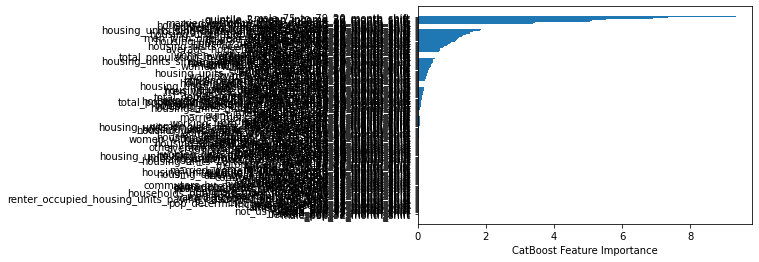

In [25]:

plt.Figure(figsize=[20,20])
plt.barh(feat_names, model.feature_importances_[sorted_feature_importance])
plt.xlabel("CatBoost Feature Importance")

In [26]:
STOP!

SyntaxError: invalid syntax (2635050600.py, line 1)

### Catboost with non-shifted values, but cut-off from 2014-2018

In [ ]:
merged_frame = helper.time_lag_merge(main_frame, acs)
merged_frame = helper.time_lag_merge(main_frame, acs2)

# earliest_date = merged_frame['Time'].dt.time.min()
# train_test_date = pd.to_datetime('1122017', format = '%d%m%Y')
# latest_date = pd.to_datetime('1122018', format = '%d%m%Y')

earliest_date = datetime.datetime(2014,1,1)
train_test_date = datetime.datetime(2017,12,1)
latest_date = datetime.datetime(2018,12,1)

## Cut off dates before earliest date and after lastest one
print(f'original shape: {merged_frame.shape}')
merged_frame_cut = merged_frame[merged_frame['Time'] > earliest_date]

print(f'after first cut: {merged_frame_cut.shape}')
merged_frame_cut = merged_frame[merged_frame['Time'] < latest_date]

print(f'final: {merged_frame_cut.shape}')

In [ ]:
## Check MSNO
merged_frame_cut = merged_frame_cut.sort_values(by='Time')
msno.matrix(merged_frame_cut)

In [ ]:
## Drop na values
merged_frame_cut = merged_frame_cut.dropna()
merged_frame_cut = merged_frame_cut.reset_index(drop=True)
print(f'shape: {merged_frame_cut.shape}')

In [ ]:
## Check for categoricals
merged_frame_cut.info()

In [ ]:
## Train will be before 12/1/2017, test is from 12/1/2017 to 12/1/2017
merged_train = merged_frame_cut[merged_frame_cut['Time'] < train_test_date]
merged_test  = merged_frame_cut[merged_frame_cut['Time'] > train_test_date]

In [ ]:
## Set features and target for test, train

y_train = merged_train[target_name]
y_test = merged_test[target_name]
X_test = merged_test.drop(columns=['zip_code', 'Time', target_name], axis=1)
X_train = merged_train.drop(columns=['zip_code', 'Time', target_name], axis=1)


In [ ]:
STOP!

In [ ]:
### Run Catboost
# Testing performance
# RMSE: 161.08420537715583
# R2: 0.5135635682520305

train_dataset = cb.Pool(X_train, y_train)
test_dataset = cb.Pool(X_test, y_test)
model = cb.CatBoostRegressor(loss_function='RMSE')
grid = {'iterations': [100, 150, 100], 
       'learning_rate': [0.03, 01.], 
       'depth': [2,4,6,8], 
       'l2_leaf_reg': [0.2, 0.5, 1, 3]}

model.grid_search(grid, train_dataset)
feat_names = X_test.columns.to_list()

pred = model.predict(X_test)
rmse = (np.sqrt(mean_squared_error(y_test, pred)))
r2 = r2_score(y_test, pred)

print("Testing performance")
print(f'RMSE: {rmse}')
print(f'R2: {r2}')



In [ ]:
sorted_feature_importance = model.feature_importances_.argsort()
plt.Figure(figsize=[20,20])
plt.barh(feat_names, model.feature_importances_[sorted_feature_importance])
plt.xlabel("CatBoost Feature Importance")

### Catboost

In [ ]:
train_dataset = cb.Pool(X_train, y_train)
test_dataset = cb.Pool(X_test, y_test)

In [ ]:
model = cb.CatBoostRegressor(loss_function='RMSE')

In [ ]:
grid = {'iterations': [100, 150, 100], 
       'learning_rate': [0.03, 01.], 
       'depth': [2,4,6,8], 
       'l2_leaf_reg': [0.2, 0.5, 1, 3]}

model.grid_search(grid, train_dataset)

In [ ]:
feat_names = X_test.columns.to_list()

In [ ]:
pred = model.predict(X_test)
rmse = (np.sqrt(mean_squared_error(y_test, pred)))
r2 = r2_score(y_test, pred)

print("Testing performance")
print(f'RMSE: {rmse}')
print(f'R2: {r2}')

In [ ]:
sorted_feature_importance = model.feature_importances_.argsort()
plt.barh(feat_names, model.feature_importances_[sorted_feature_importance])
plt.xlabel("CatBoost Feature Importance")